# FN6809 Linear Financial Models
**Group 9** Members:<br><br>
HU ZIHAO<br>
KONG FANJI<br>
SHI XUEER<br>
XU SHUMING<br>
ZHOU XUAN

## 1. Data Exploratory

### 1.1 Loading Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal

import re
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler


from itertools import combinations
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import importlib
# import linear_utils
# importlib.reload(linear_utils)
from linear_utils import *


In [3]:
df = pd.read_csv("used_cars.csv")
df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


Although *model_year* is the only numerical feature, *milage* and *price* are supposed to be in numerical format as well.

In [5]:
df['milage'] = df['milage'].replace(to_replace=r',', value='', regex=True)   # Remove commas
df['milage'] = df['milage'].replace(to_replace=r' mi\.', value='', regex=True)  # Remove ' mi.' suffix
df['milage'] = pd.to_numeric(df['milage'], errors='coerce').astype(float)  # Convert to numeric type, coercing invalid data to NaN
df['milage']

0       51000.0
1       34742.0
2       22372.0
3       88900.0
4        9835.0
         ...   
4004      714.0
4005    10900.0
4006     2116.0
4007    33000.0
4008    43000.0
Name: milage, Length: 4009, dtype: float64

In [6]:
df['price'] = df['price'].replace(to_replace=r'\$', value='', regex=True)   # Remove the dollar sign
df['price'] = df['price'].replace(to_replace=r',', value='', regex=True)    # Remove commas
df['price'] = pd.to_numeric(df['price'], errors='coerce').astype(float)  # Convert to numeric type, coercing invalid data to NaN
df['price']

0        10300.0
1        38005.0
2        54598.0
3        15500.0
4        34999.0
          ...   
4004    349950.0
4005     53900.0
4006     90998.0
4007     62999.0
4008     40000.0
Name: price, Length: 4009, dtype: float64

### 1.2 Data Summary

A basic description of numerical features of the dataset

In [7]:
df.describe()

,model_year,milage,price
count,4009.000000,4009.000000,4.009000e+03
mean,2015.515590,64717.551010,4.455319e+04
std,6.104816,52296.599459,7.871064e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,23044.000000,1.720000e+04
50%,2017.000000,52775.000000,3.100000e+04
75%,2020.000000,94100.000000,4.999000e+04
max,2024.000000,405000.000000,2.954083e+06


A basic description of categorical features of the dataset

In [8]:
df.describe(include=['object', 'category'])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,4009,4009,3839,4009,4009,4009,4009,3896,3413
unique,57,1898,7,1146,62,319,156,2,1
top,Ford,M3 Base,Gasoline,2.0L I4 16V GDI DOHC Turbo,A/T,Black,Black,None reported,Yes
freq,386,30,3309,52,1037,905,2025,2910,3413


<a id='null'></a>
### 1.3 Analysis of Null Values

In [9]:
missing = df.isnull().sum().reset_index()
missing.columns = ['Features','Missing_Count']
missing['%Missing'] = missing['Missing_Count']/df.shape[0]*100
missing[missing['Missing_Count']>0]

,Features,Missing_Count,%Missing
4,fuel_type,170,4.240459
9,accident,113,2.818658
10,clean_title,596,14.866550


Apparently, the dataset only has 3 features with null values. Next, each of 3 features/predictors will be examined to extract potentailly useful insights.

In [10]:
# Analysing fuel_type
df_fuel = df.copy()
df_fuel['fuel_type'] = df_fuel['fuel_type'].fillna('NA')
df_fuel.groupby('fuel_type')['price'].median().reset_index().sort_values(by='price', ascending=True)

,fuel_type,price
6,not supported,14000.0
7,–,15300.0
1,E85 Flex Fuel,19500.0
2,Gasoline,29950.0
5,Plug-In Hybrid,44945.0
0,Diesel,45450.0
3,Hybrid,45499.0
4,NA,46999.0


**Insights:**<br><br>
It’s notable that missing fuel type ('NA') has one of the highest median prices (46,999), which could indicate that this data is missing not randomly. Perhaps luxury or higher-end vehicles are more likely to have incomplete data for some reason, or it could be that this field was omitted for certain vehicles due to data entry issues. Thus, null values shoule be treated as a new category.


In [11]:
# Analysing accident
df_accident = df.copy()
df_accident['accident'] = df_accident['accident'].fillna('NA')
df_accident.groupby('accident')['price'].median().reset_index().sort_values(by='price',ascending = True)

,accident,price
0,At least 1 accident or damage reported,20900.0
2,None reported,35667.5
1,NA,36500.0


**Insights:**<br><br>
The median price for entries marked as 'NA' is 36,500, which is close to the "None reported" category. This indicates that vehicles with missing accident information are still perceived similarly to those without reported accidents, suggesting that feature *accident* of these vehicles could be treated as "None reported".

In [12]:
df_clean_title = df.copy()
df_clean_title['clean_title'] = df_clean_title['clean_title'].fillna('NA')
df_clean_title.groupby('clean_title')['price'].median().reset_index().sort_values(by='price',ascending = True)

,clean_title,price
1,Yes,29000.0
0,NA,42996.5


**Insights:**<br><br>
The NA values for clean_title also have a significantly higher median price and will be treated as a separate category.

### 1.4 Outlier Detection

#### 1.4.1 Price

<Axes: xlabel='price'>

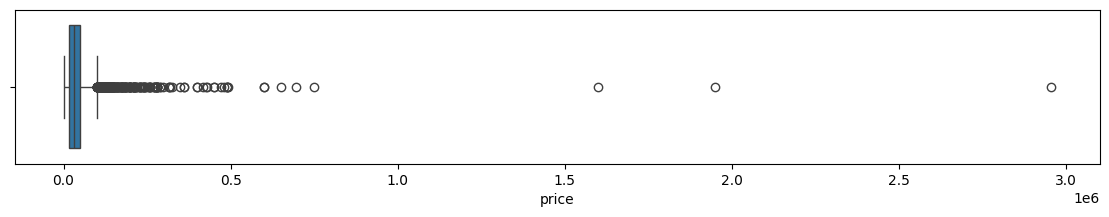

In [13]:
plt.figure(figsize=(14,2))

sns.boxplot(df.price,orient='h')

In [14]:
outlier_data = df.copy()

iqr = outlier_data.price.quantile(.75) - outlier_data.price.quantile(0.25)
l_limit = outlier_data.price.quantile(0.25) - iqr*1.5
u_limit = outlier_data.price.quantile(0.75) + iqr*1.5

indx = outlier_data[(outlier_data.price<l_limit) | (outlier_data.price>u_limit)].index
print(len(indx), f'Outliers Detected Using IQR({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
     f'\t\t| Price at Upper Limit: {u_limit}')

for i in range(10):
    u_limit = outlier_data.price.quantile(0.90+i/100)
    indx = outlier_data[(outlier_data.price>u_limit)].index
    print(len(indx),
          f'Outliers Detected Using {0.9*100+i} percentile({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
         f'\t| Price at {0.9*100+i} percentile: {outlier_data.price.quantile(0.9+i/100)}')


244 Outliers Detected Using IQR(6.09%) 		| Price at Upper Limit: 99175.0
399 Outliers Detected Using 90.0 percentile(9.95%) 	| Price at 90.0 percentile: 79999.0
361 Outliers Detected Using 91.0 percentile(9.0%) 	| Price at 91.0 percentile: 84627.0
318 Outliers Detected Using 92.0 percentile(7.93%) 	| Price at 92.0 percentile: 89000.0
280 Outliers Detected Using 93.0 percentile(6.98%) 	| Price at 93.0 percentile: 93999.0
241 Outliers Detected Using 94.0 percentile(6.01%) 	| Price at 94.0 percentile: 99852.0
201 Outliers Detected Using 95.0 percentile(5.01%) 	| Price at 95.0 percentile: 111599.99999999991
158 Outliers Detected Using 96.0 percentile(3.94%) 	| Price at 96.0 percentile: 129000.0
121 Outliers Detected Using 97.0 percentile(3.02%) 	| Price at 97.0 percentile: 149803.9999999999
81 Outliers Detected Using 98.0 percentile(2.02%) 	| Price at 98.0 percentile: 197099.16000000035
41 Outliers Detected Using 99.0 percentile(1.02%) 	| Price at 99.0 percentile: 272713.2800000002


*94.0 percentile could be used as a threshold for mapping the outliers' values (i.e. all outliers' values converted to 94.0 percentile)*

#### 1.4.2 Milage

<Axes: xlabel='milage'>

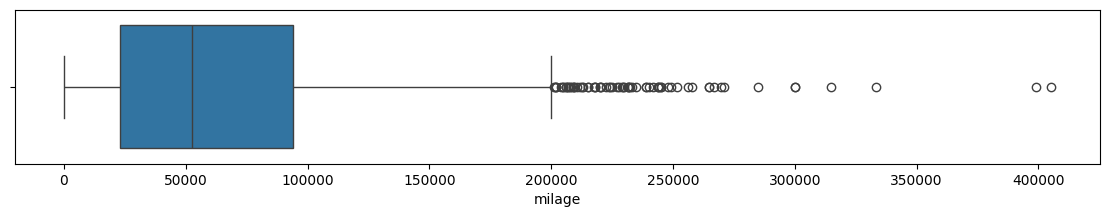

In [15]:
plt.figure(figsize=(14,2))

sns.boxplot(df.milage,orient='h')

In [16]:
outlier_data = df.copy()

iqr = outlier_data.milage.quantile(.75) - outlier_data.milage.quantile(0.25)
l_limit = outlier_data.milage.quantile(0.25) - iqr*1.5
u_limit = outlier_data.milage.quantile(0.75) + iqr*1.5

indx = outlier_data[(outlier_data.milage<l_limit) | (outlier_data.milage>u_limit)].index
print(len(indx), f'Outliers Detected Using IQR({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
     f'\t\t| Milage at Upper Limit: {u_limit}')


for i in range(6):
    u_limit = outlier_data.milage.quantile(0.95+i/100)
    indx = outlier_data[(outlier_data.milage>u_limit)].index
    print(len(indx),
          f'Outliers Detected Using {0.95*100+i} percentile({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
         f'\t| Price at {0.95*100+i} percentile: {outlier_data.milage.quantile(0.95+i/100)}')

69 Outliers Detected Using IQR(1.72%) 		| Milage at Upper Limit: 200684.0
200 Outliers Detected Using 95.0 percentile(4.99%) 	| Price at 95.0 percentile: 165000.0
161 Outliers Detected Using 96.0 percentile(4.02%) 	| Price at 96.0 percentile: 171535.27999999988
118 Outliers Detected Using 97.0 percentile(2.94%) 	| Price at 97.0 percentile: 185000.0
81 Outliers Detected Using 98.0 percentile(2.02%) 	| Price at 98.0 percentile: 195477.76
41 Outliers Detected Using 99.0 percentile(1.02%) 	| Price at 99.0 percentile: 222428.00000000015
0 Outliers Detected Using 100.0 percentile(0.0%) 	| Price at 100.0 percentile: 405000.0


Since only less than 2% of records' milage are identified as outliers,we could simply drop them or mapping them to iqr*1.5+0.75 quantile

### 1.5 Numerical Features Analysis

#### 1.5.1 Visualizations of Numerical Variables

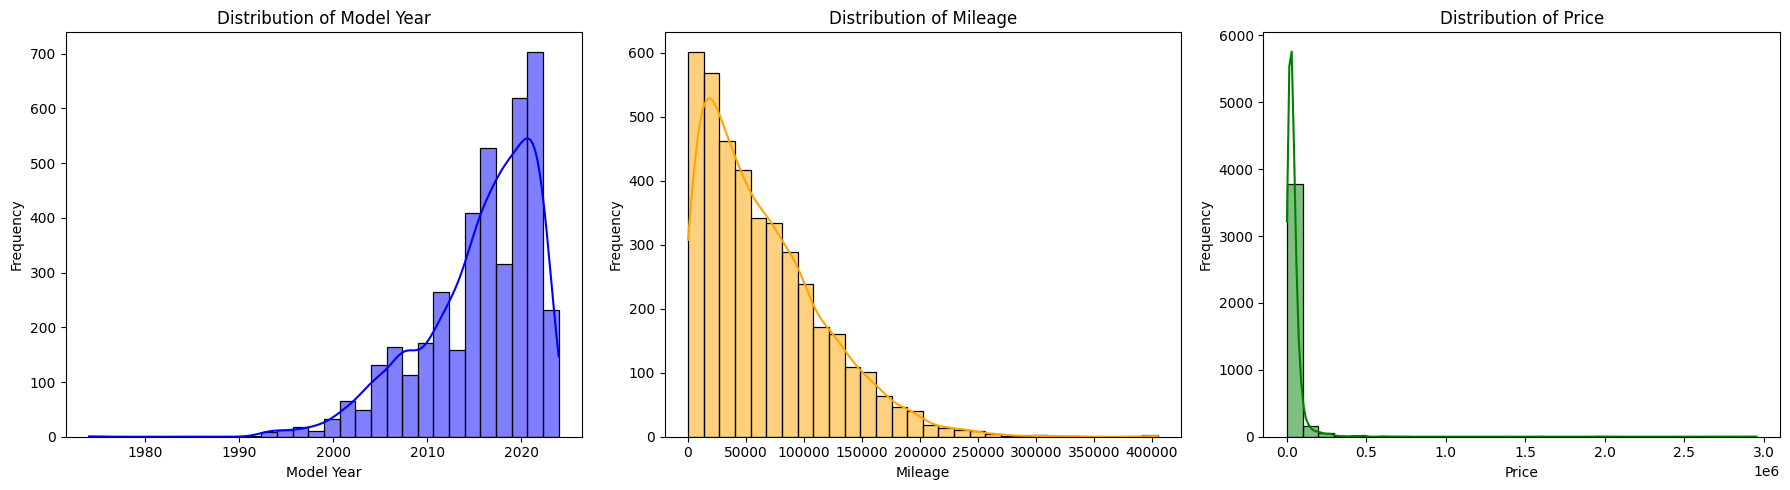

In [17]:
# Create a figure for the histograms
plt.figure(figsize=(18, 5))

# Histogram for model_year
plt.subplot(1, 3, 1)
sns.histplot(df['model_year'], bins=30, kde=True, color='blue')
plt.title('Distribution of Model Year')
plt.xlabel('Model Year')
plt.ylabel('Frequency')

# Histogram for mileage
plt.subplot(1, 3, 2)
sns.histplot(df['milage'], bins=30, kde=True, color='orange')
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')

# Histogram for price
plt.subplot(1, 3, 3)
sns.histplot(df['price'], bins=30, kde=True, color='green')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

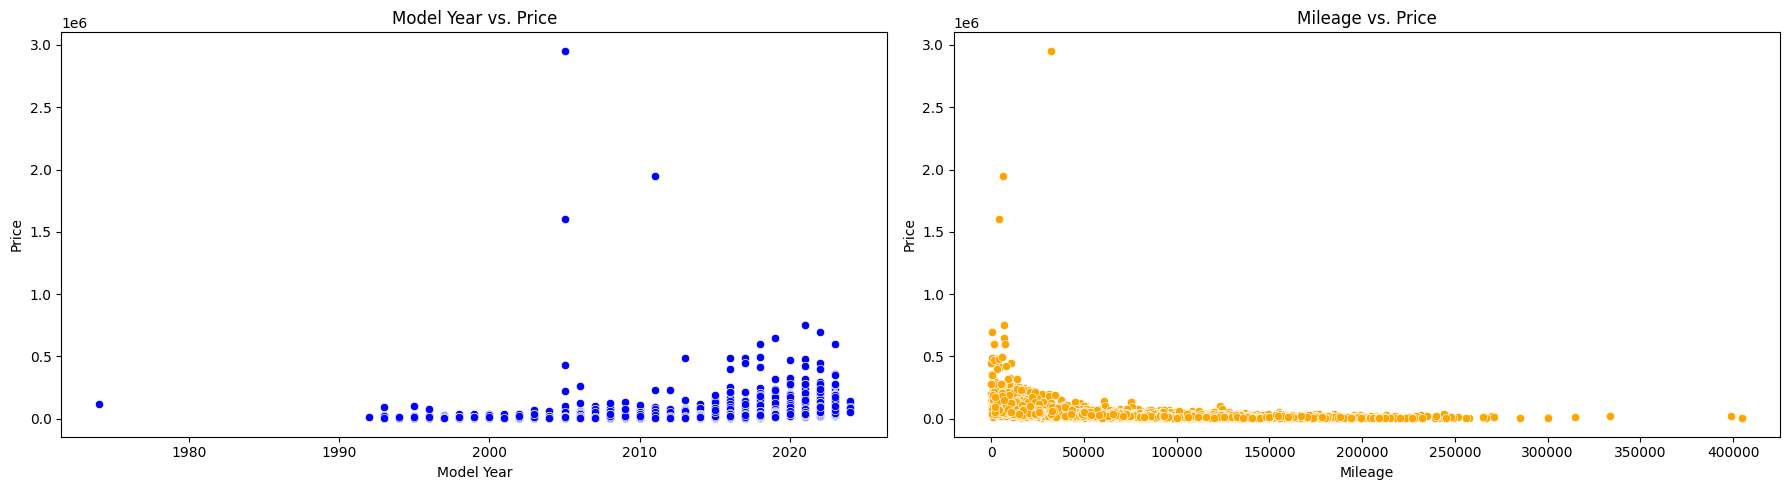

In [18]:
# Create a figure for the scatter plots
plt.figure(figsize=(18, 5))

# Scatter plot for model_year vs price
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='model_year', y='price', color='blue')
plt.title('Model Year vs. Price')
plt.xlabel('Model Year')
plt.ylabel('Price')

# Scatter plot for mileage vs price
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='milage', y='price', color='orange')
plt.title('Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

#### 1.5.2 Correlation Analysis

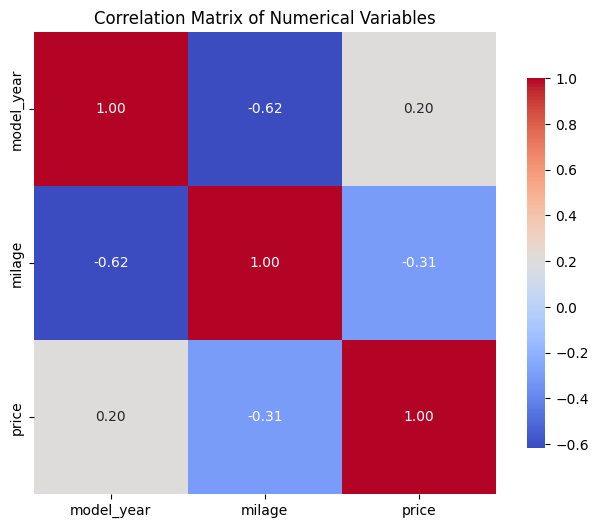

In [19]:
correlation_matrix = df[['model_year', 'milage', 'price']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### 1.6 Categorical Features Analysis

#### 1.6.1 Brand

In [20]:
# Analysing brand
brand_df = df.groupby('brand')['price'].agg(['count','mean','median','min','max']).reset_index()
brand_df['count%'] = brand_df['count']/df.shape[0]*100
brand_df.sort_values(by='count',ascending=False).reset_index(drop=True)

,brand,count,mean,median,min,max,count%
0,Ford,386,3.624088e+04,32377.5,3000.0,429998.0,9.628336
1,BMW,375,4.107231e+04,32999.0,2500.0,145000.0,9.353954
2,Mercedes-Benz,315,5.207577e+04,38598.0,4750.0,425000.0,7.857321
3,Chevrolet,292,3.672274e+04,31992.5,4000.0,179000.0,7.283612
4,Porsche,201,8.875130e+04,59900.0,8500.0,1599000.0,5.013719
5,Audi,200,3.990743e+04,34497.5,5500.0,187900.0,4.988775
6,Toyota,199,3.002600e+04,27999.0,2500.0,91995.0,4.963831
7,Lexus,163,3.566852e+04,30000.0,3500.0,159000.0,4.065852
8,Jeep,143,3.109979e+04,30000.0,4500.0,84620.0,3.566974
9,Land,130,5.576406e+04,44924.0,5750.0,199998.0,3.242704


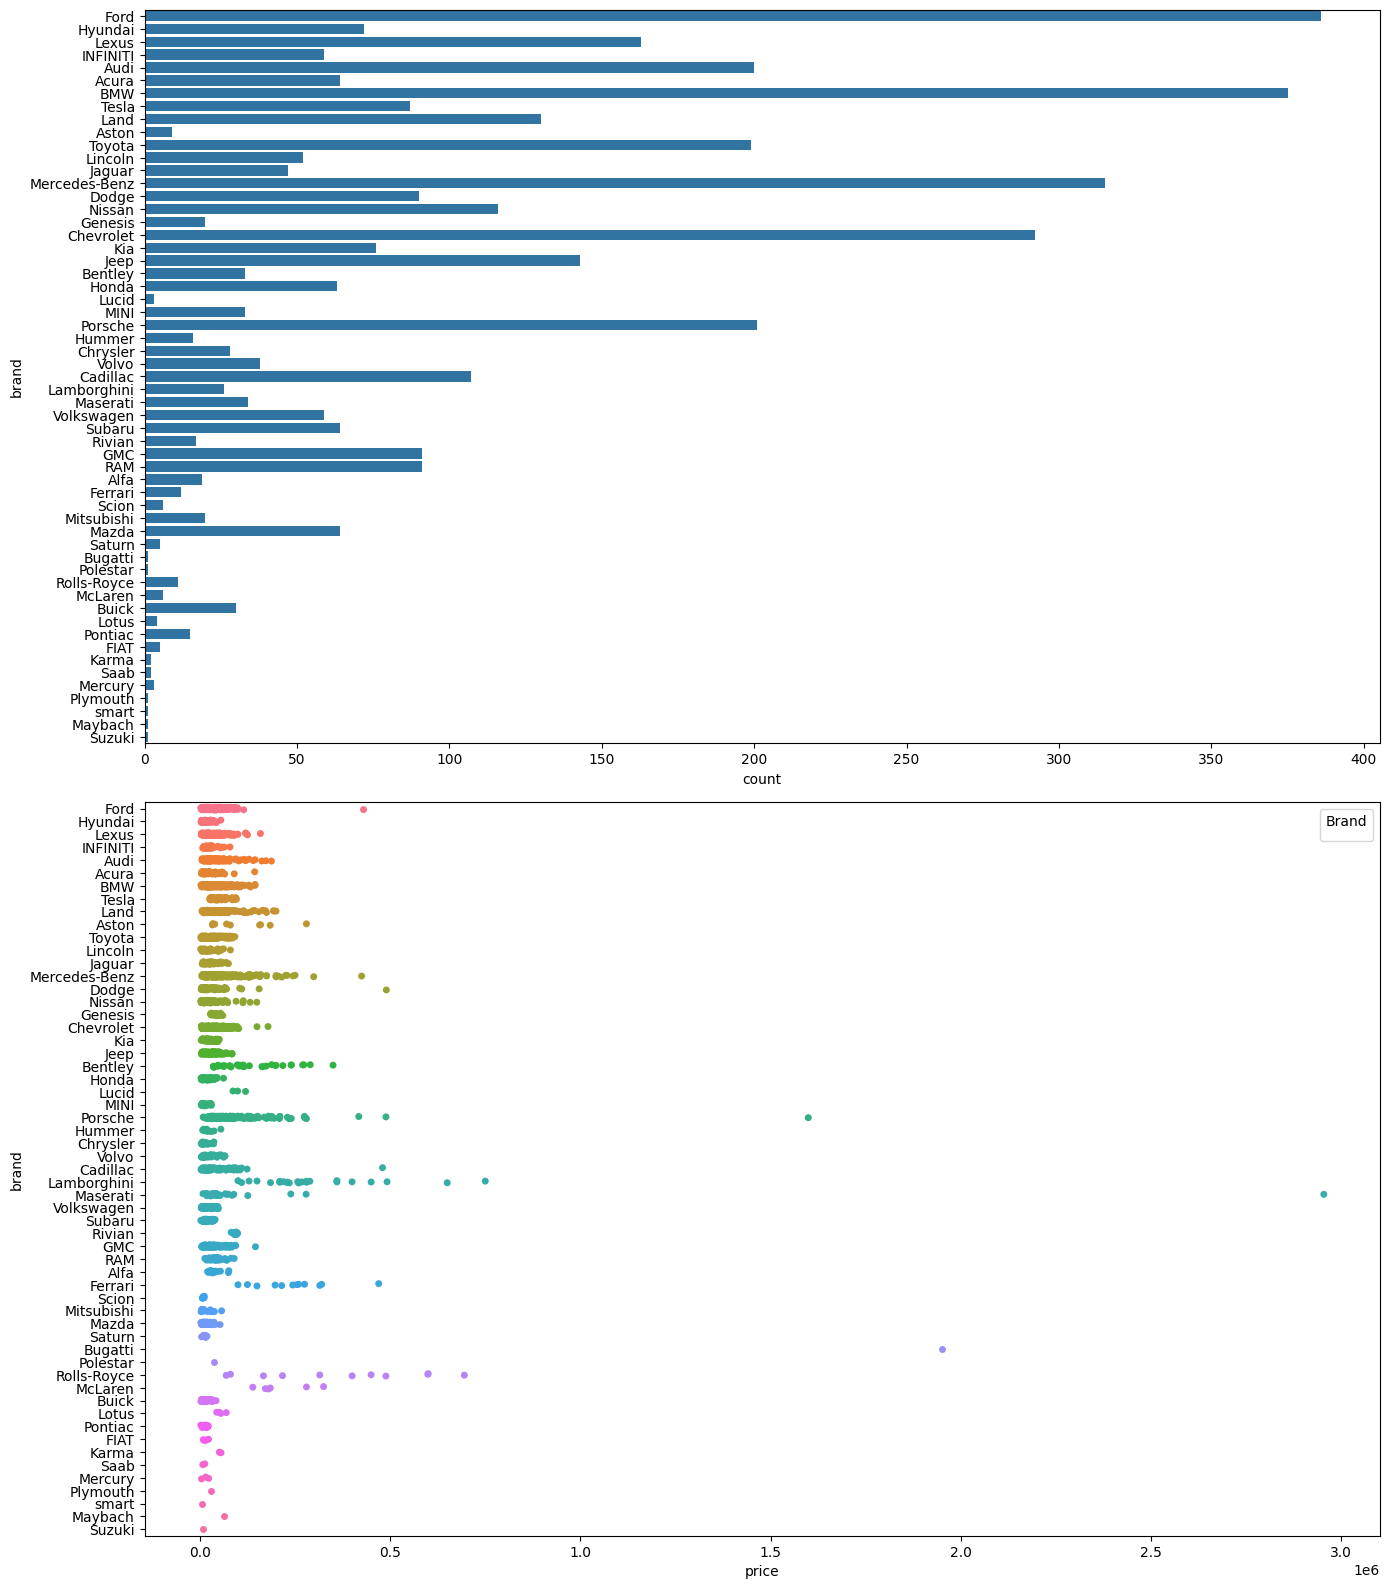

In [21]:
plt.figure(figsize=(14, 16))

# Horizontal countplot
plt.subplot(211)
sns.countplot(y=df['brand'])  # Changed x to y for horizontal orientation
# plt.xticks(rotation=45)  # This might not be necessary for a horizontal plot

plt.subplot(212)
sns.stripplot(y=df['brand'], x=df['price'], hue=df['brand'], jitter=True)  # Switched x and y
# plt.xticks(rotation=45)
plt.legend([], title='Brand')  # Optional: Add a title for clarity

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [22]:
grp = [val.values for name,val in df.groupby('brand')['price']]
print(kruskal(*grp))

KruskalResult(statistic=np.float64(992.1679282337675), pvalue=np.float64(2.092814239885586e-171))


**Purpose of the Kruskal-Wallis Test** <br><br>
Hypothesis Testing: The Kruskal-Wallis H test is a non-parametric test used to determine if there are statistically significant differences between the medians of three or more independent groups. In your case, these groups are defined by the different brand categories.

*H0: All group medians are equal (i.e., there is no difference in car prices across different brands).*

*Ha: At least one group median is different.*

**Insights:**<br><br>
Few brands have higher means and median and can be consider luxury brands (e.g. Ferrari, Rolls Royals, Lamborgini, etc)


#### 1.6.2 Model

In [23]:
# Analysing model
print('Total Unique Model:',df.model.nunique())
model_df = df.groupby('model')['price'].agg(['count','mean','median','std','min','max']).reset_index()
model_df['count%'] = model_df['count']/df.shape[0]*100
model_df.sort_values(by='count',ascending=False).reset_index(drop=True).head(10)

Total Unique Model: 1898


,model,count,mean,median,std,min,max,count%
0,M3 Base,30,35322.400000,30499.5,15184.132456,15000.0,84645.0,0.748316
1,F-150 XLT,24,36340.708333,35997.0,9651.287332,15000.0,58504.0,0.598653
2,Corvette Base,22,26390.227273,27250.0,9077.846199,9900.0,39500.0,0.548765
3,1500 Laramie,18,46542.500000,46799.0,3246.195968,34918.0,51074.0,0.448990
4,Model Y Long Range,17,45129.117647,46500.0,5825.925601,35500.0,56515.0,0.424046
5,Camaro 2SS,17,38167.647059,39000.0,10493.911050,19500.0,54900.0,0.424046
6,Wrangler Sport,17,21903.705882,22000.0,9170.622380,5500.0,40995.0,0.424046
7,Mustang GT Premium,16,30886.875000,29745.0,9727.642207,18500.0,49500.0,0.399102
8,911 Carrera,16,93339.875000,102946.5,35614.980290,35000.0,149000.0,0.399102
9,M4 Base,15,57909.066667,60995.0,12240.041202,32999.0,81000.0,0.374158


In [24]:
unique_model_df = df.groupby('brand')['model'].nunique().reset_index()
unique_model_df.sort_values(by='model',ascending=False).reset_index(drop=True)

,brand,model
0,BMW,145
1,Ford,142
2,Mercedes-Benz,130
3,Audi,118
4,Chevrolet,116
5,Toyota,98
6,Land,72
7,Porsche,71
8,Nissan,62
9,Cadillac,56


#### 1.6.3 Fuel Type

In [25]:
# Analysing fuel type
fuel_data = df.copy()
fuel_data['fuel_type'] = fuel_data.fuel_type.fillna('NA')

fuel_df = fuel_data.groupby(['fuel_type'])['price'].agg(['count','mean','median','std','min','max']).reset_index()
fuel_df

,fuel_type,count,mean,median,std,min,max
0,Diesel,116,48695.422414,45450.0,27381.267682,5000.0,200000.0
1,E85 Flex Fuel,139,22744.115108,19500.0,13408.175874,4500.0,79950.0
2,Gasoline,3309,44538.525839,29950.0,85051.948855,2000.0,2954083.0
3,Hybrid,194,51426.195876,45499.0,32416.663809,4400.0,175000.0
4,NA,170,54413.176471,46999.0,26347.578229,4200.0,146000.0
5,Plug-In Hybrid,34,45946.176471,44945.0,22842.978818,10000.0,86999.0
6,not supported,2,14000.000000,14000.0,6363.961031,9500.0,18500.0
7,–,45,35745.888889,15300.0,89678.365882,2500.0,599995.0


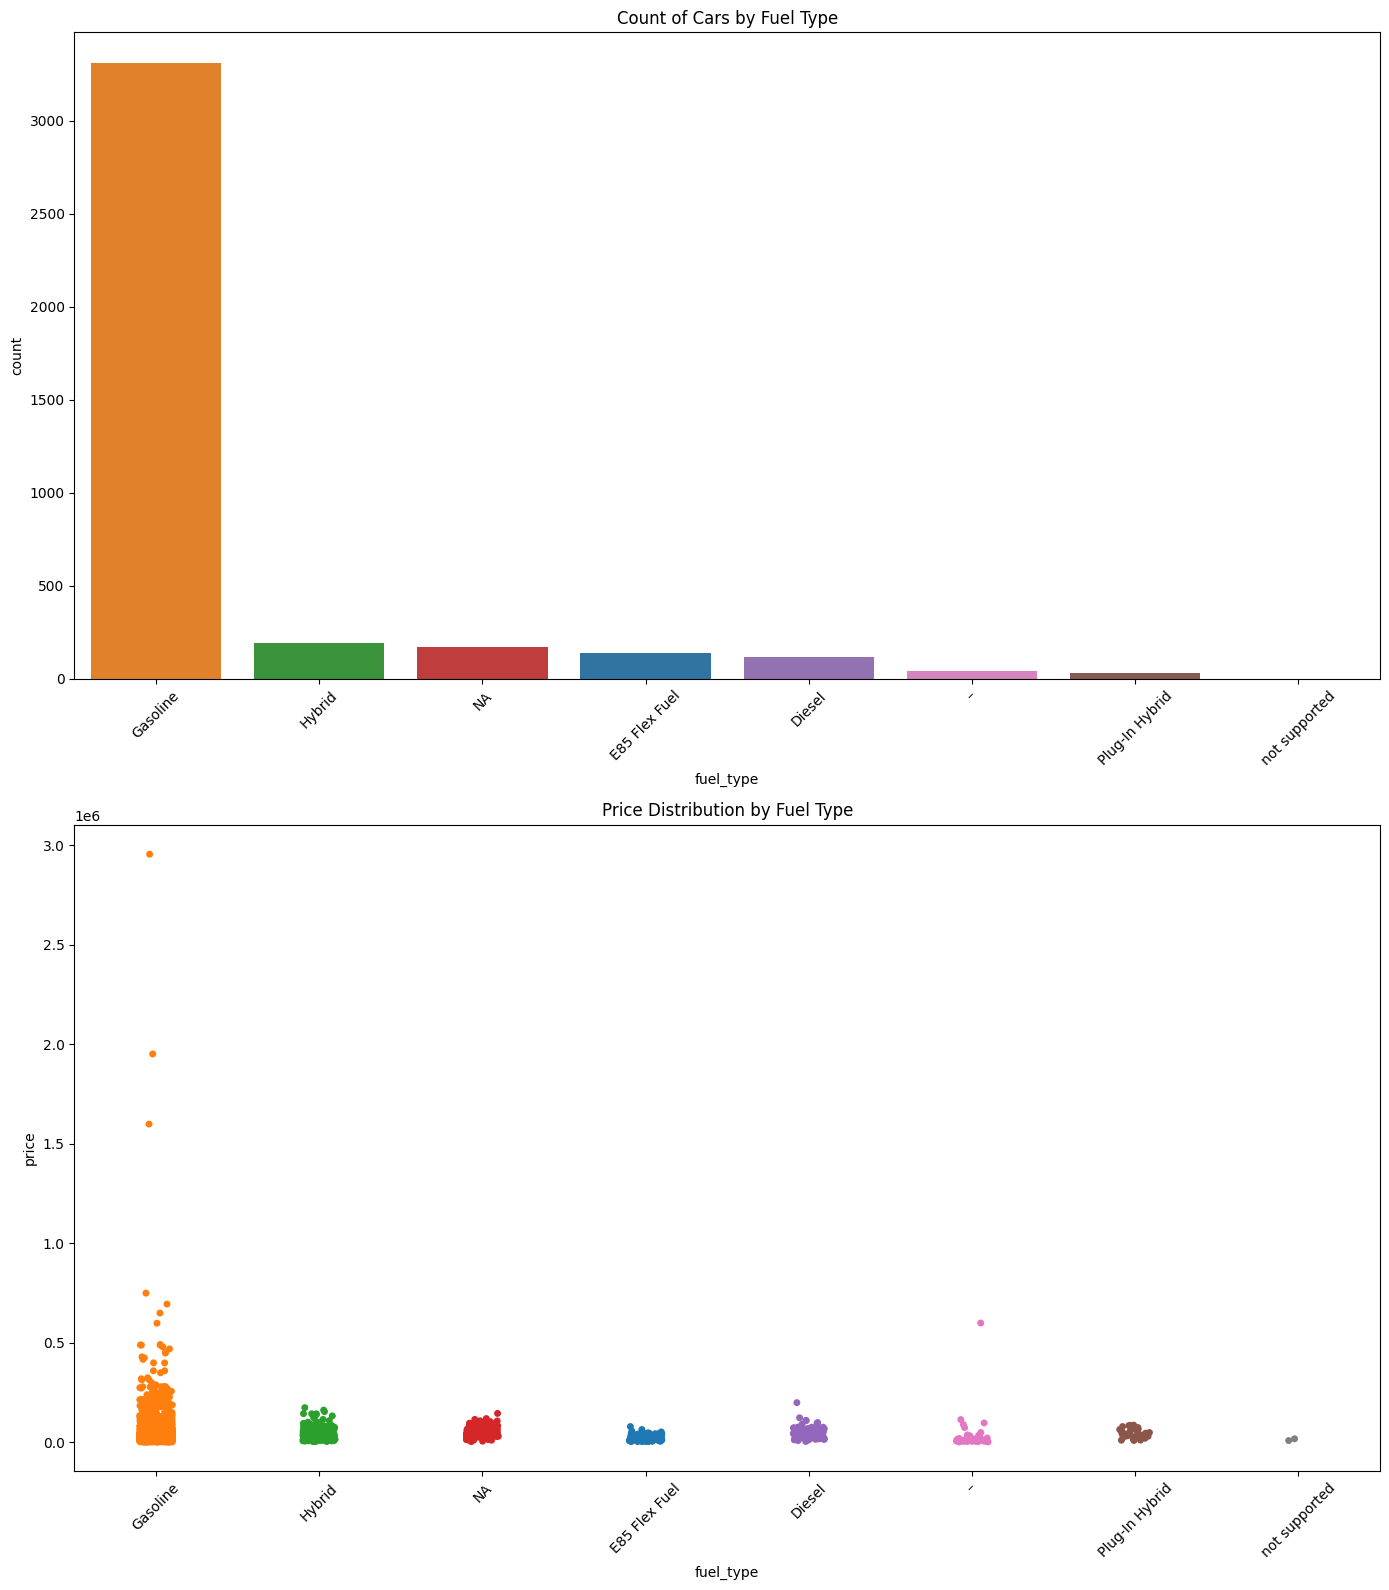

In [26]:
fuel_counts = fuel_data['fuel_type'].value_counts()

# Create a sorted list of fuel types based on counts
sorted_fuel_types = fuel_counts.index

plt.figure(figsize=(14, 16))

# Subplot for countplot
plt.subplot(211)
sns.countplot(x=fuel_data.fuel_type, hue=fuel_data.fuel_type, order=sorted_fuel_types)
plt.xticks(rotation=45)
plt.title('Count of Cars by Fuel Type')

# Subplot for stripplot
plt.subplot(212)
sns.stripplot(x=fuel_data.fuel_type, y=fuel_data.price, hue=fuel_data.fuel_type, order=sorted_fuel_types)
plt.xticks(rotation=45)
plt.title('Price Distribution by Fuel Type')
plt.legend([],[], frameon=False)  # Remove the legend for clarity

plt.tight_layout()
plt.show()


**Insights:**<br><br>
Gasoline vehicles dominate the market while hybrids command higher median prices. Diesel vehicles also have a notable median price of 45,450. High standard deviation in gasoline prices (85,051) indicates a wide range of models.<br><br> *Indeed, more fuel types could be extracted from engine or model names. This could be taken into consideration in section 2. Data Processing*

#### 1.6.4 Engine

By viewing the raw file, it is observed that the horsepower,engine displacement and related parameters of engine could be extracted from the name of engine as candidate predictors. Thus, instead of explore feature *engine* itself, we explore the related parameters of *engine*.

In [27]:
df['engine'].unique()

array(['300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
       '3.8L V6 24V GDI DOHC', '3.5 Liter DOHC', ...,
       '136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel',
       '270.0HP 2.0L 4 Cylinder Engine Gasoline Fuel',
       '420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel'], dtype=object)

In [28]:
engine_data = df.copy()
# horsepower
engine_data['hp'] = engine_data.engine.apply(get_hp)
# engine displacement
engine_data['engine_'] = engine_data.engine.apply(get_engine)
# cylinder configuration
engine_data['cylinder'] = engine_data.engine.apply(get_cylinder)
# fuel injection type
engine_data['fi'] = engine_data.engine.apply(get_fi)
# turbocharger
engine_data['turbo'] = engine_data.engine.apply(get_turbo)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/542782982.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.scatterplot(x=engine_data.hp.fillna(engine_data.hp.median()),y=engine_data.price,hue=engine_data.fuel_type)


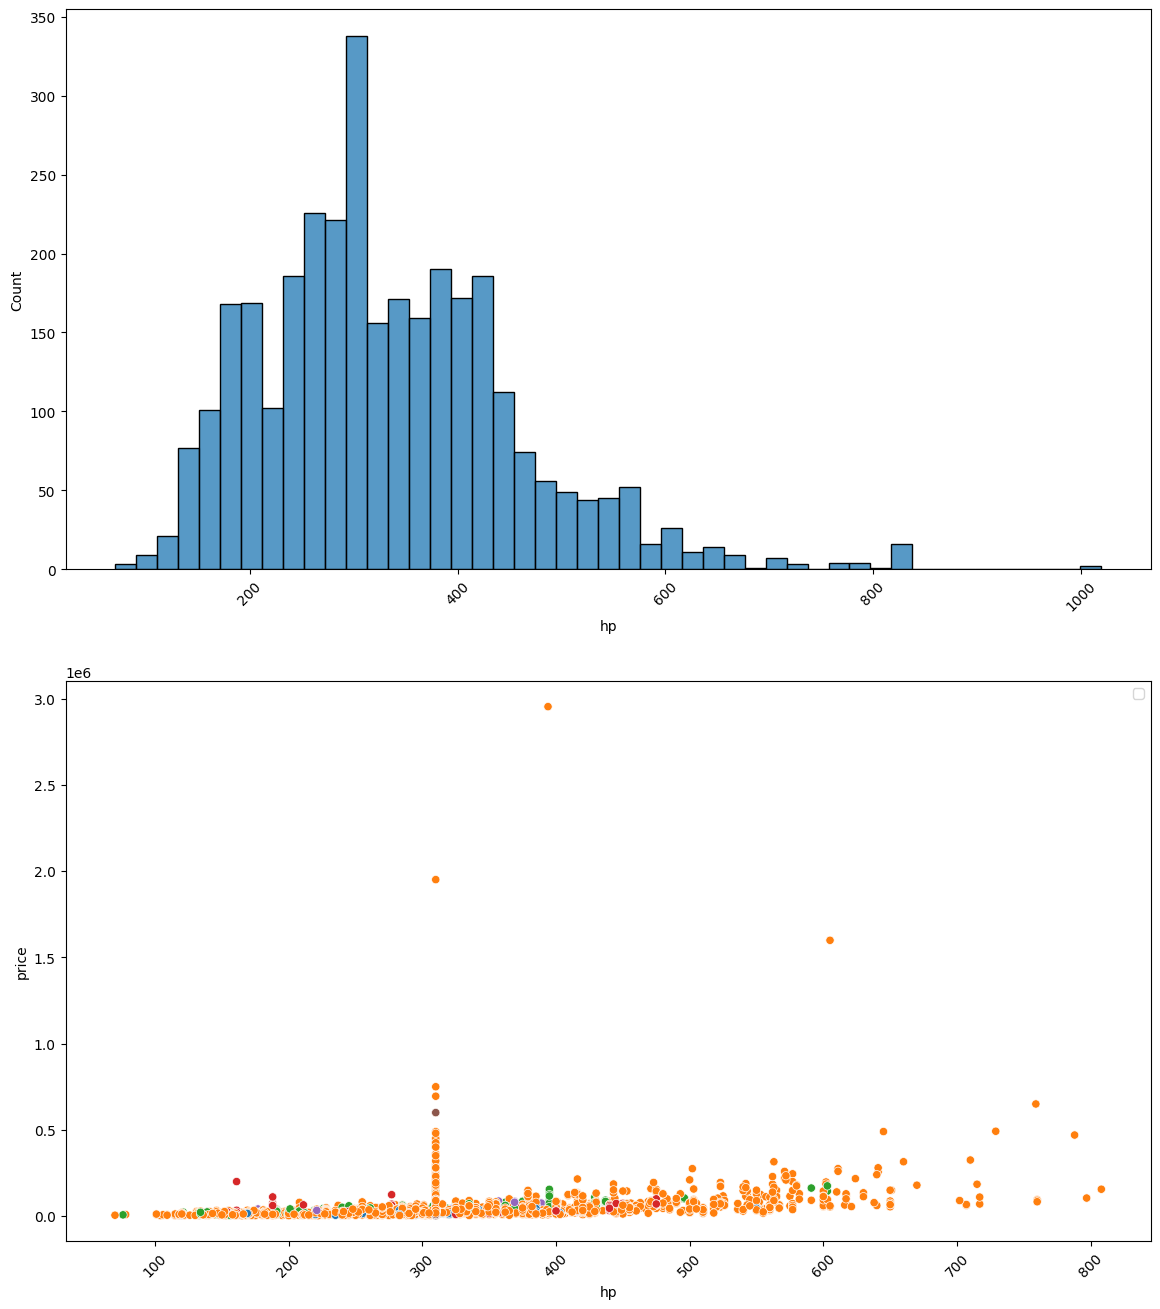

Correlation Cofficient: hp    0.601492
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/542782982.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',engine_data[['hp']].fillna(engine_data.hp.median()).corrwith(engine_data.price,method='spearman'))


In [29]:
# Analysing HP
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=engine_data.hp.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.scatterplot(x=engine_data.hp.fillna(engine_data.hp.median()),y=engine_data.price,hue=engine_data.fuel_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',engine_data[['hp']].fillna(engine_data.hp.median()).corrwith(engine_data.price,method='spearman'))


**Insights:**<br><br>
The correlation coefficient between horsepower (HP) and price suggests a positive correlation. This indicates that as horsepower increases, price tends to increase slightly, but the relationship is not significantly strong.


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/3132186633.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.scatterplot(x=engine_data.engine_.fillna(engine_data.engine_.median()),y=engine_data.price,hue=engine_data.fuel_type)


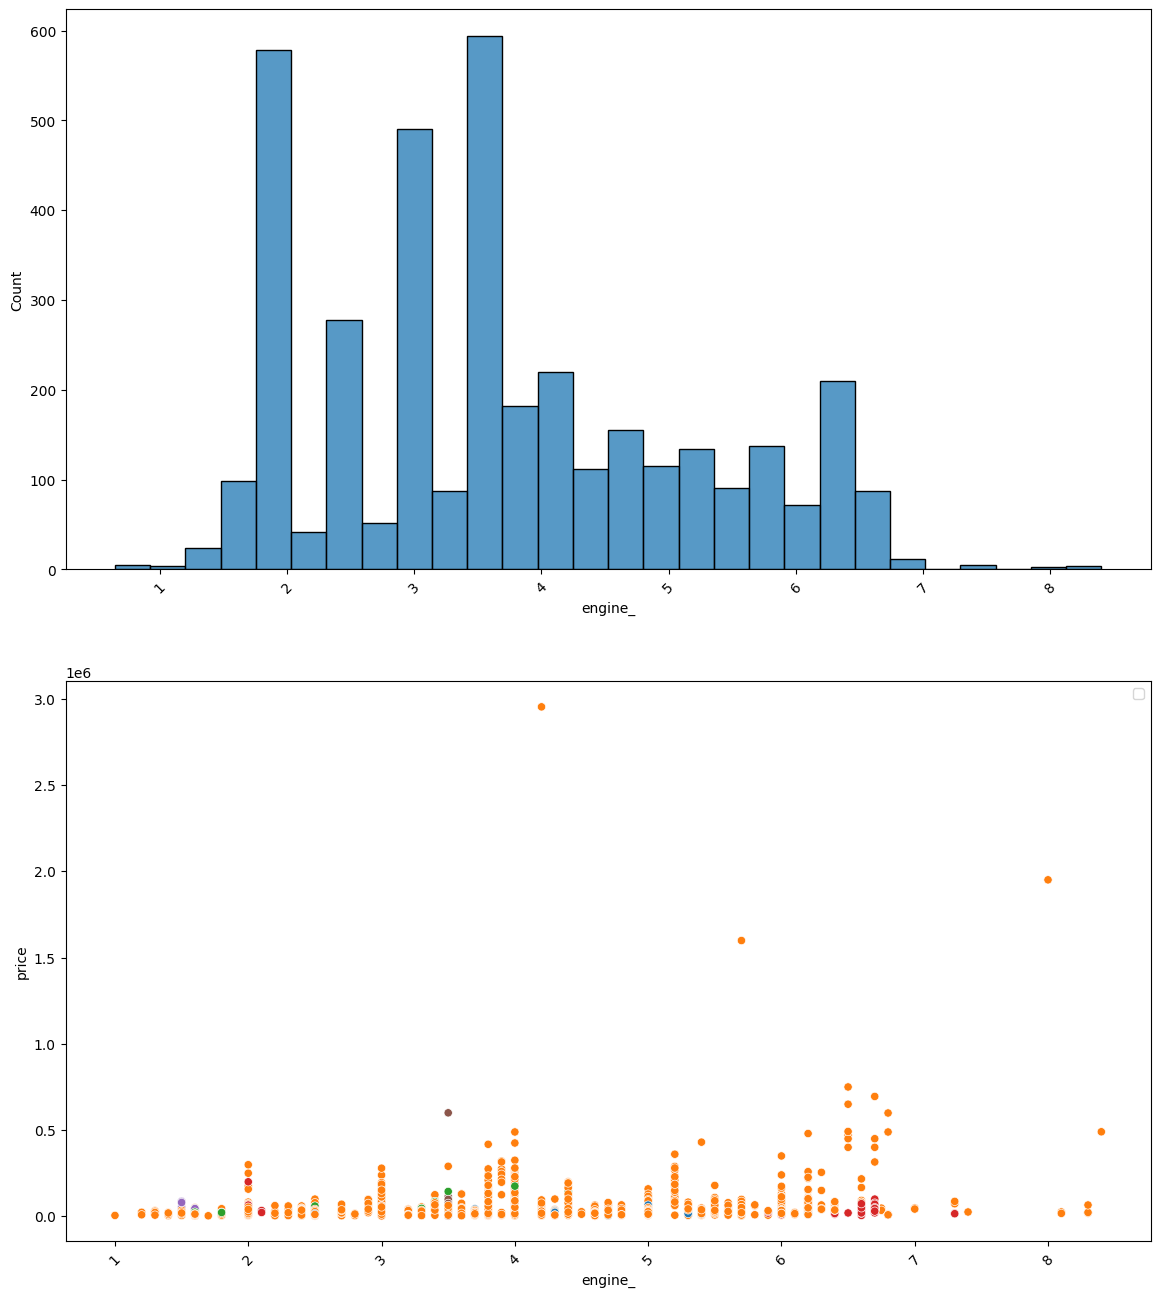

Correlation Cofficient: engine_    0.245694
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/3132186633.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',engine_data[['engine_']].fillna(engine_data.engine_.median()).corrwith(engine_data.price,method='spearman'))


In [30]:
# Analysing Engine volumn
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=engine_data.engine_.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.scatterplot(x=engine_data.engine_.fillna(engine_data.engine_.median()),y=engine_data.price,hue=engine_data.fuel_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',engine_data[['engine_']].fillna(engine_data.engine_.median()).corrwith(engine_data.price,method='spearman'))

**Insights:**<br><br>
The engine size (in liters) probably has little influence on vehicle pricing due to a relatively low correlation.



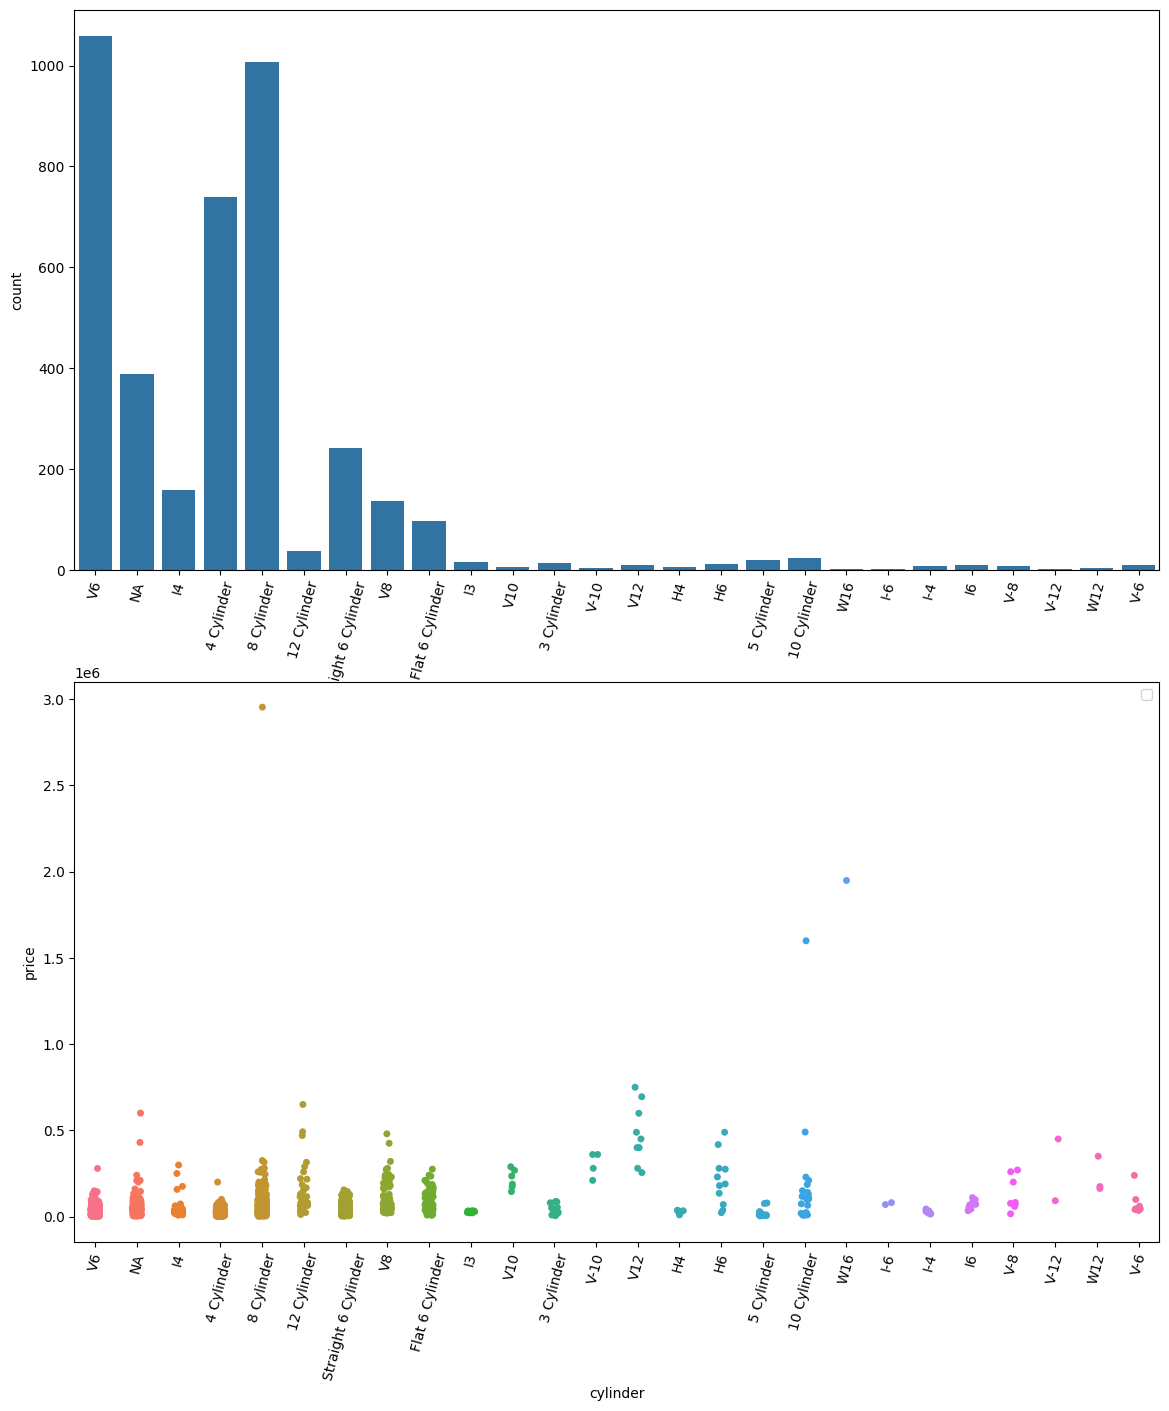

In [31]:
# Analysing cylinder
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.cylinder)
plt.xticks(rotation=75)

plt.subplot(212)
sns.stripplot(x=engine_data.cylinder,y=engine_data.price,hue=engine_data.cylinder)
plt.xticks(rotation=75)
plt.legend([])
plt.show()

In [32]:
engine_data.groupby('cylinder')['price'].agg(['count','mean','median','std']).sort_values(by='count',ascending=False).reset_index()


,cylinder,count,mean,median,std
0,V6,1058,3.135620e+04,28795.0,21735.227078
1,8 Cylinder,1007,4.640131e+04,34500.0,99167.658060
2,4 Cylinder,739,2.247564e+04,19000.0,15651.347099
3,NA,388,5.319448e+04,44998.0,46621.589178
4,Straight 6 Cylinder,242,4.170019e+04,33499.5,30612.257420
5,I4,158,3.534835e+04,29342.5,33016.022862
6,V8,137,8.729378e+04,59590.0,75210.656756
7,Flat 6 Cylinder,96,8.632265e+04,71700.0,58594.566106
8,12 Cylinder,37,1.402592e+05,81330.0,142755.434199
9,10 Cylinder,23,1.665301e+05,100000.0,330753.535864


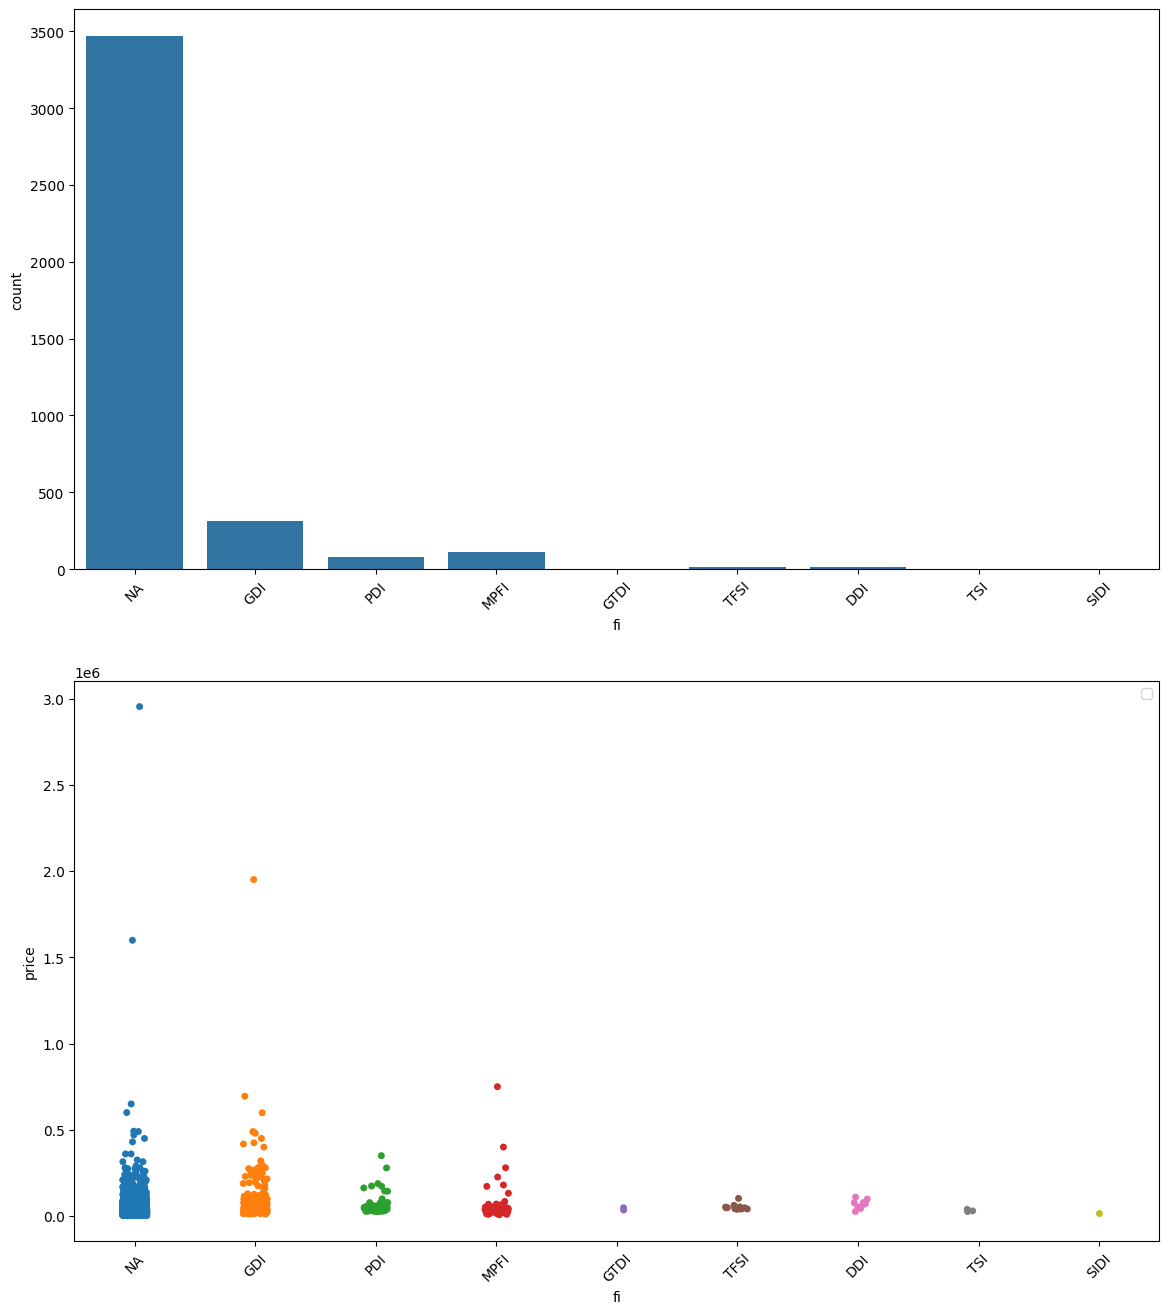

In [33]:
# Analysing fi
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.fi)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=engine_data.fi,y=engine_data.price,hue=engine_data.fi)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

In [34]:
(engine_data.groupby('fi')['price']
 .agg(['count','mean','median','std'])
 .sort_values(by='count',ascending=False)
 .reset_index())

,fi,count,mean,median,std
0,NA,3471,40660.949294,29000.0,70022.144296
1,GDI,314,79063.121019,38939.0,142354.857532
2,MPFI,114,54563.798246,41164.0,82415.468230
3,PDI,78,60838.512821,43212.5,54825.318210
4,TFSI,15,49818.000000,44998.0,15629.377101
5,DDI,11,67602.727273,69998.0,23952.646384
6,TSI,3,31498.000000,29798.0,6518.435395
7,GTDI,2,41348.000000,41348.0,8980.256121
8,SIDI,1,19998.000000,19998.0,NaN


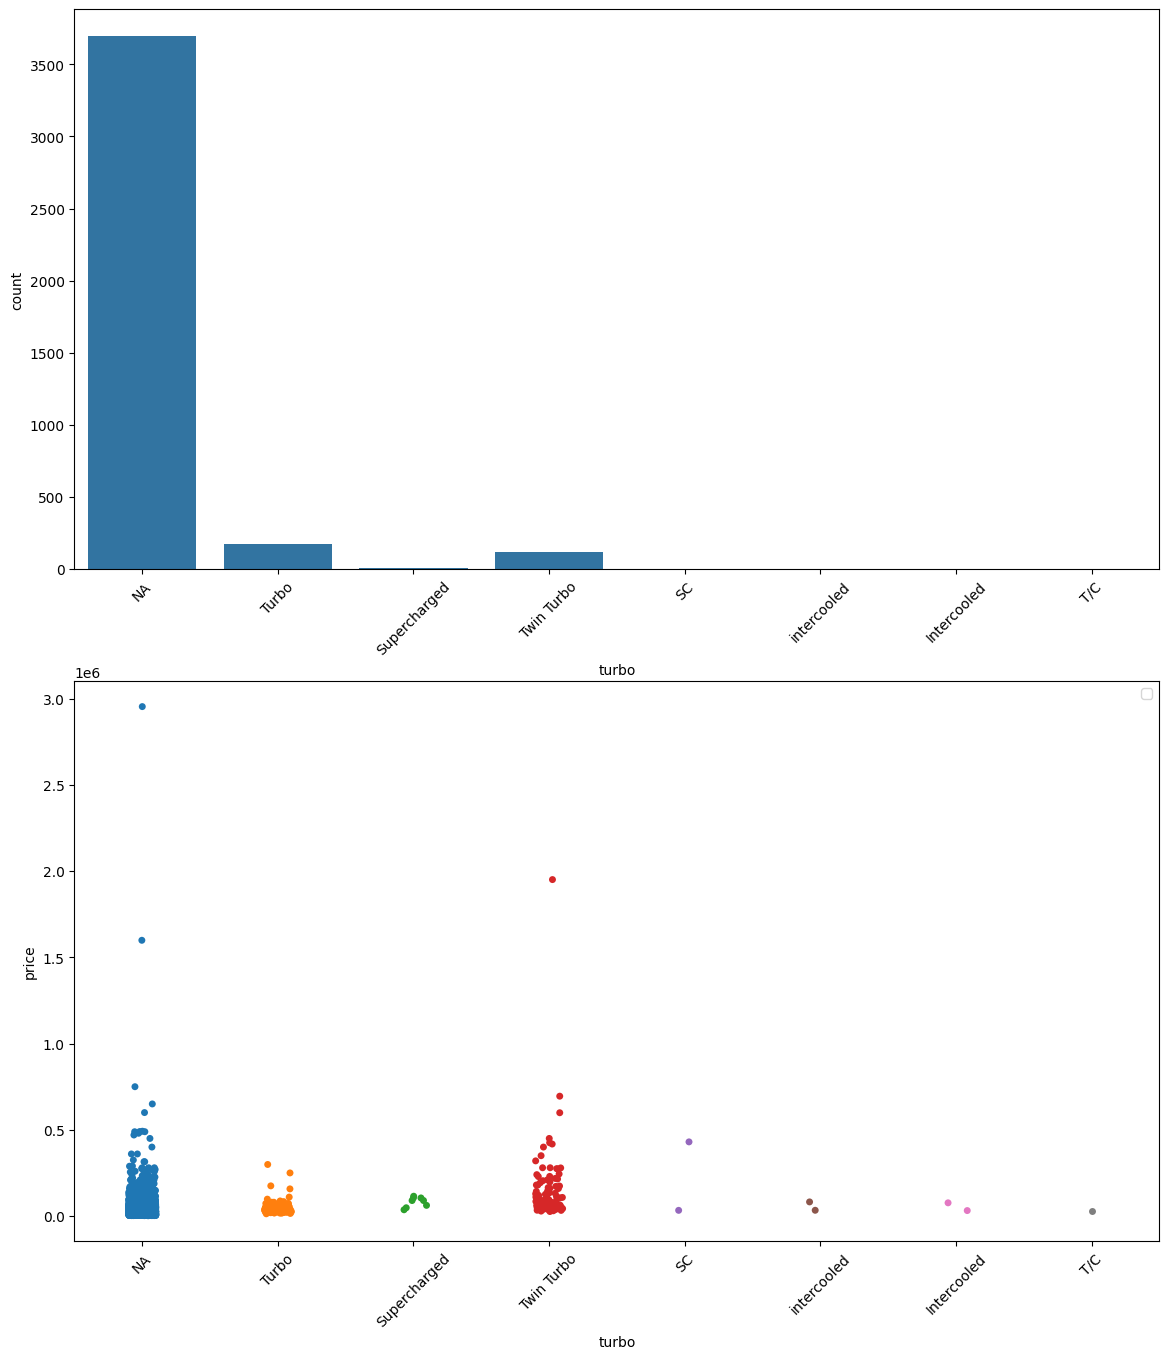

In [35]:
# Analysing turbo
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.turbo)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=engine_data.turbo,y=engine_data.price,hue=engine_data.turbo)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


#### 1.6.5 Transmission

In [36]:
# Analysing transmission
transmission_data = df.copy()

transmission_data['transmission_type'] = transmission_data.transmission.apply(get_trans_type)
transmission_data['speed'] = transmission_data.transmission.apply(get_speed)

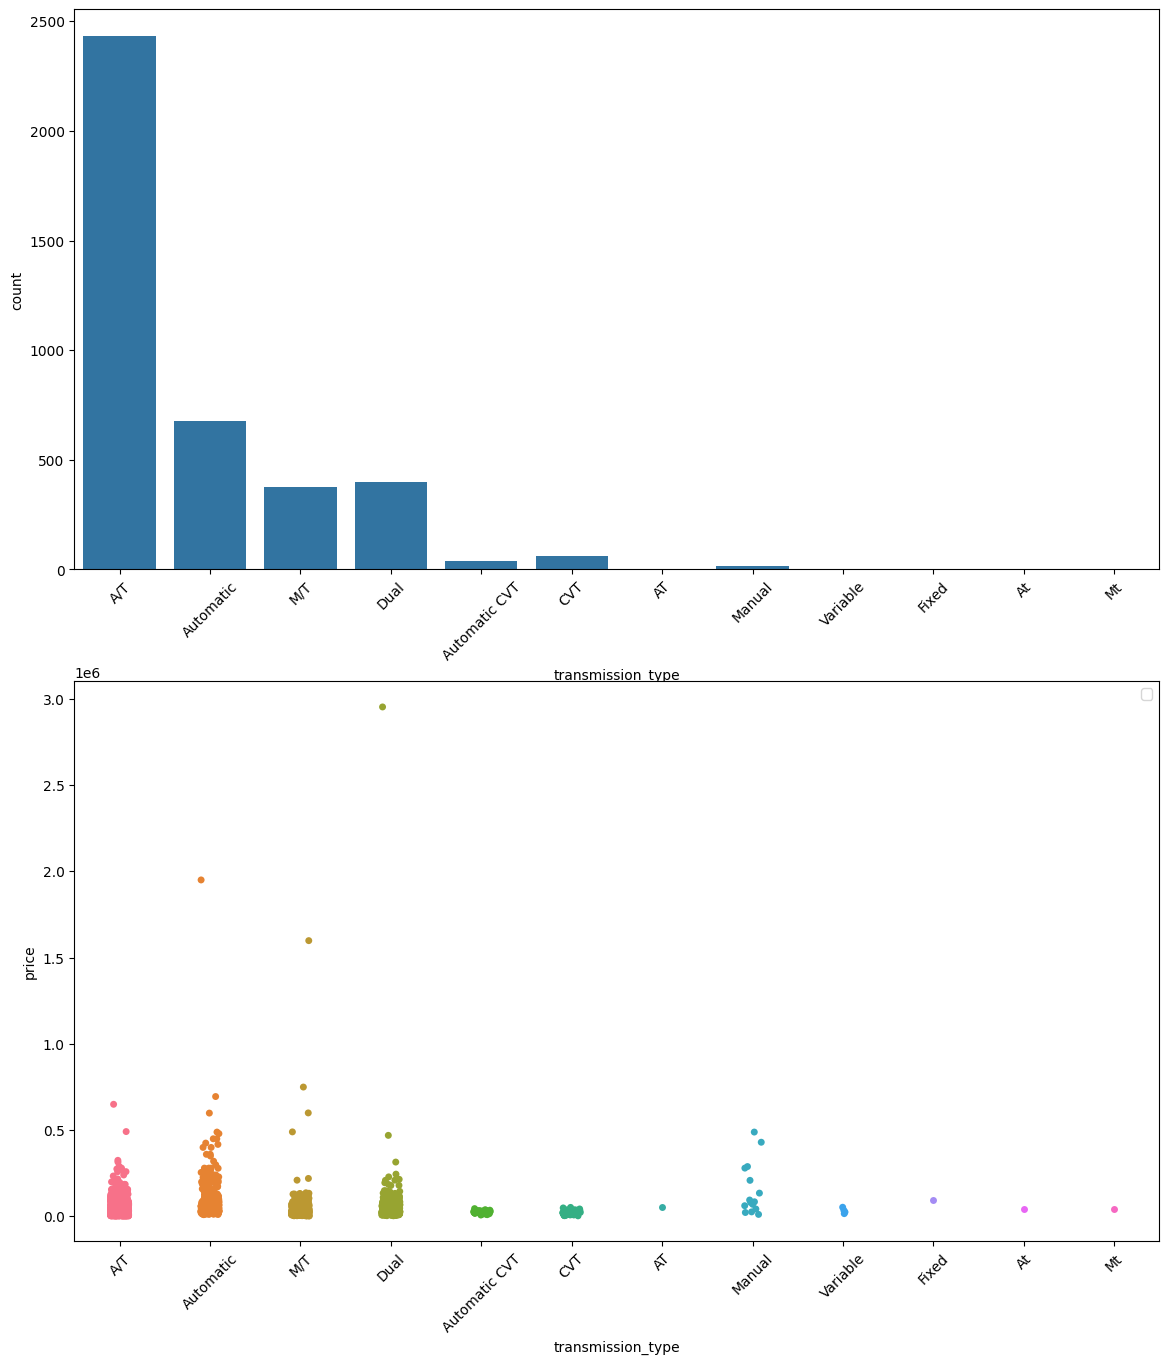

,transmission_type,count,mean,median,std
0,A/T,2433,36962.922318,28000.0,36852.969941
1,Automatic,678,68935.651917,43073.0,104099.442942
2,Dual,398,54710.615578,34000.0,152703.104130
3,M/T,377,40125.074271,23500.0,100255.992129
4,CVT,63,22086.317460,21499.0,10917.712312
5,Automatic CVT,37,25985.027027,25980.0,8123.722123
6,Manual,15,155148.666667,84645.0,151493.083896
7,Variable,4,32248.000000,29998.0,15861.378671
8,AT,1,51998.000000,51998.0,NaN
9,At,1,42998.000000,42998.0,NaN


In [37]:
# Analysing transmission type
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=transmission_data.transmission_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=transmission_data.transmission_type,y=transmission_data.price,hue=transmission_data.transmission_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

(transmission_data.groupby('transmission_type')['price']
 .agg(['count','mean','median','std'])
 .sort_values(by='count',ascending=False)
.reset_index())


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/2148668308.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_data.speed.fillna(transmission_data.speed.median()))
/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/2148668308.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_dat

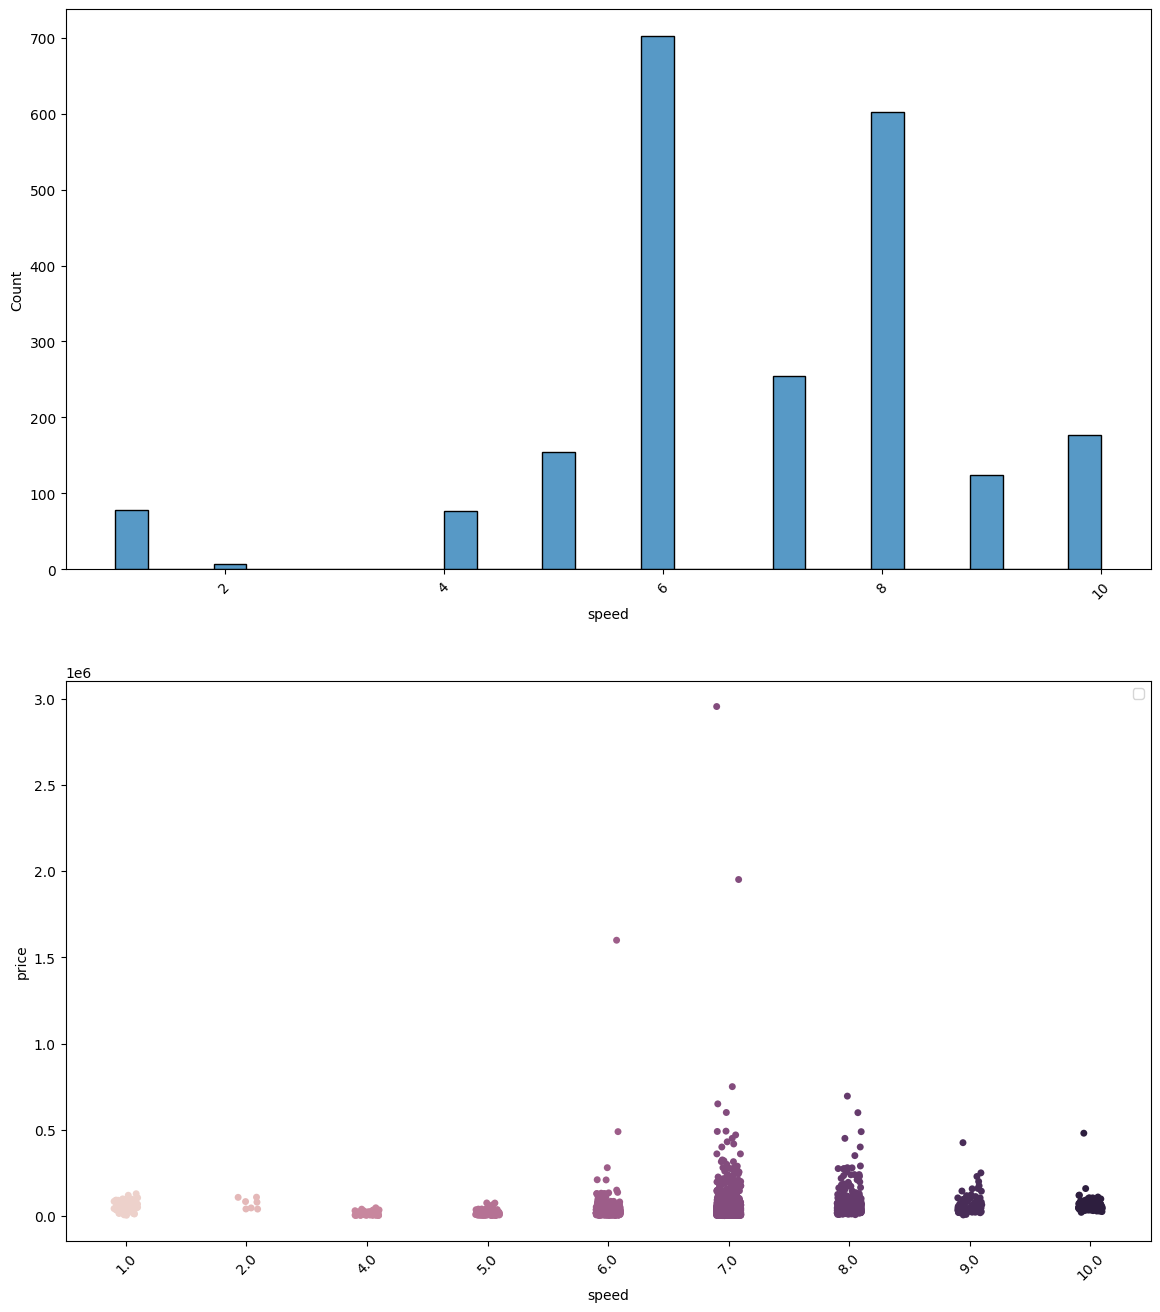

Correlation Cofficient: speed    0.331677
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/2148668308.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',transmission_data[['speed']].fillna(transmission_data.speed.median()).corrwith(transmission_data.price,method='spearman'))


In [38]:
# Analysing speed
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=transmission_data.speed.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_data.speed.fillna(transmission_data.speed.median()))
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',transmission_data[['speed']].fillna(transmission_data.speed.median()).corrwith(transmission_data.price,method='spearman'))


#### 1.6.6 Color

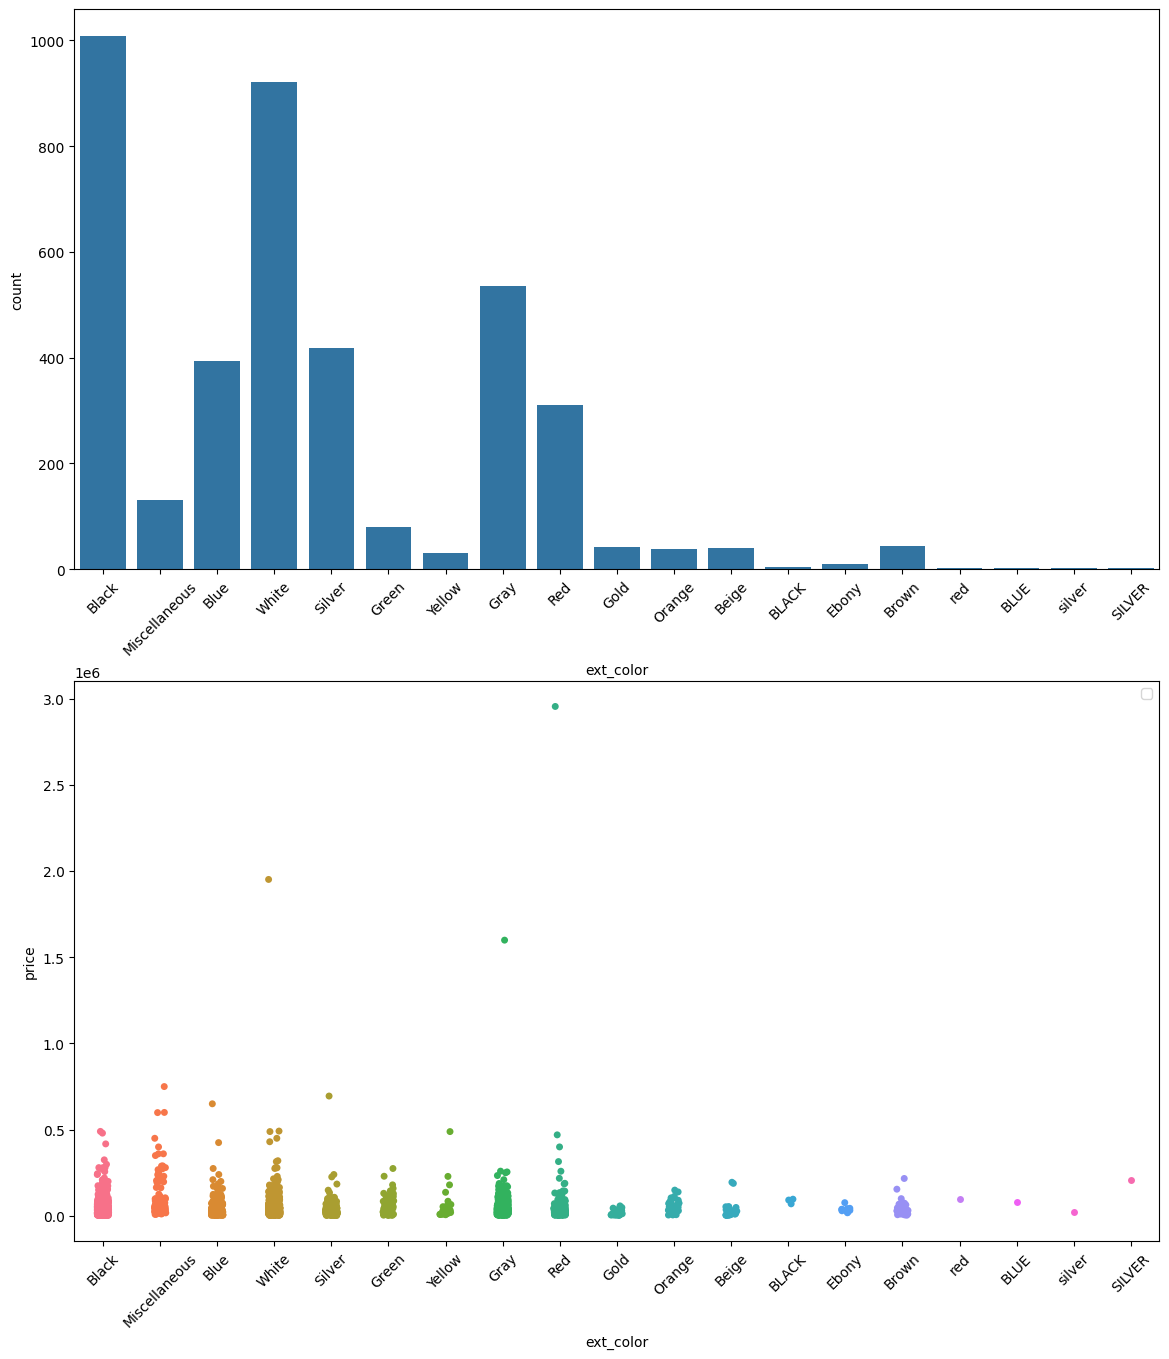

In [39]:
# Analysing External Color
color_data = df.copy()

color_data['ext_color'] = color_data['ext_col'].apply(get_color)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.ext_color)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.ext_color,y=color_data.price,hue=color_data.ext_color)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


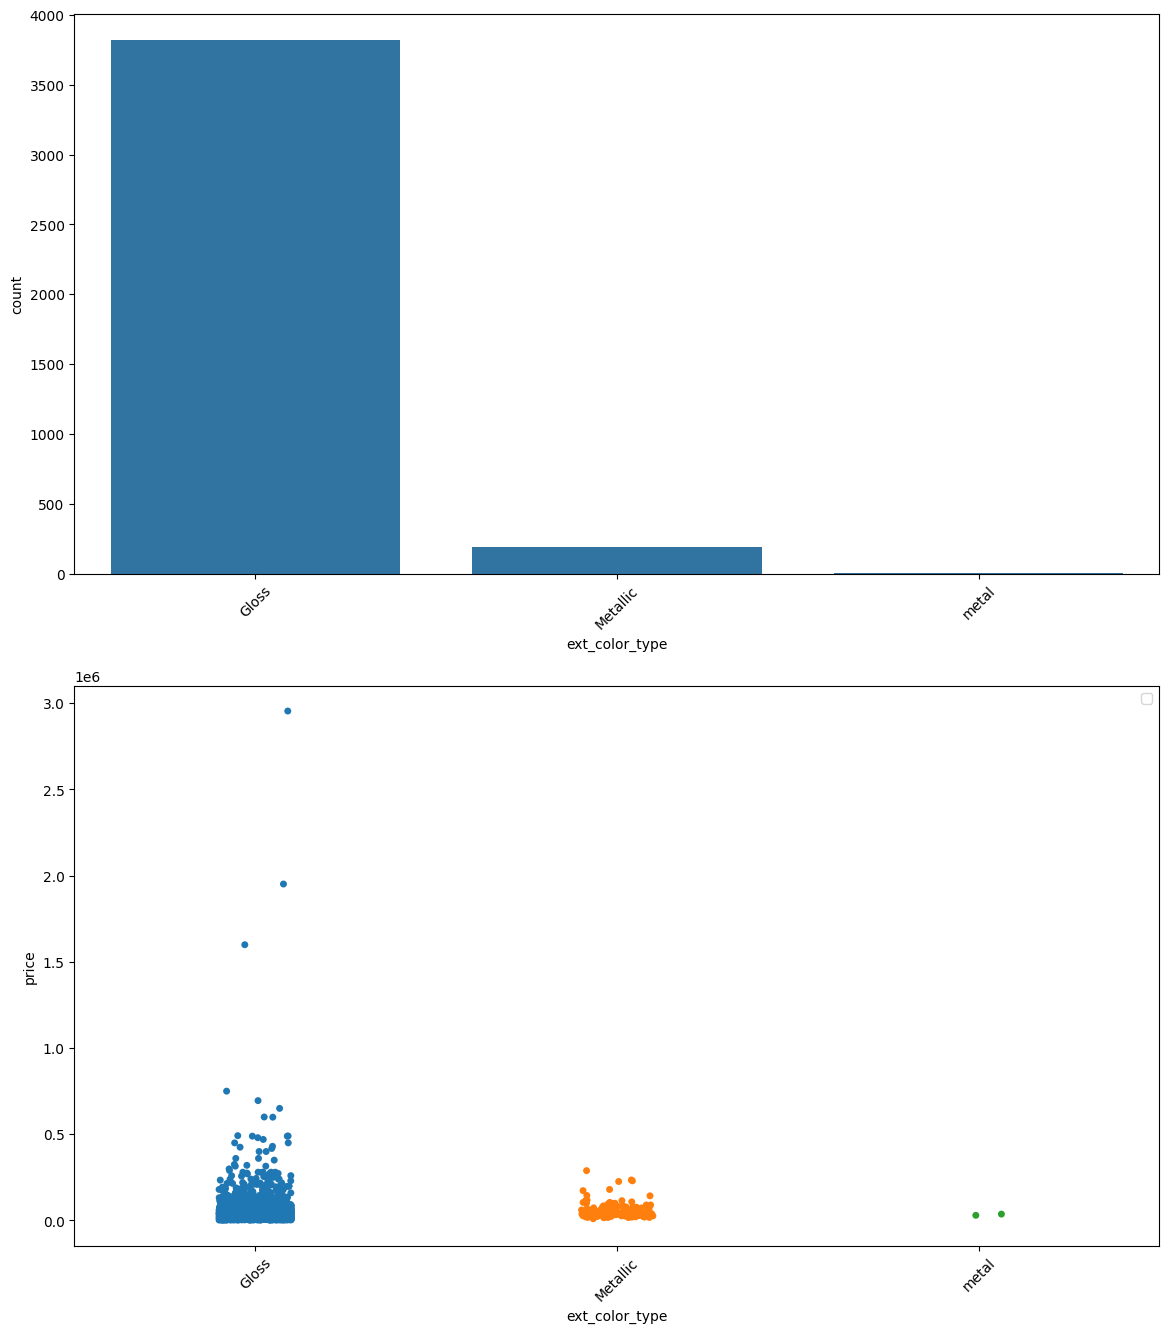

In [40]:
color_data['ext_color_type'] = color_data['ext_col'].apply(get_color_type)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.ext_color_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.ext_color_type,y=color_data.price,hue=color_data.ext_color_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


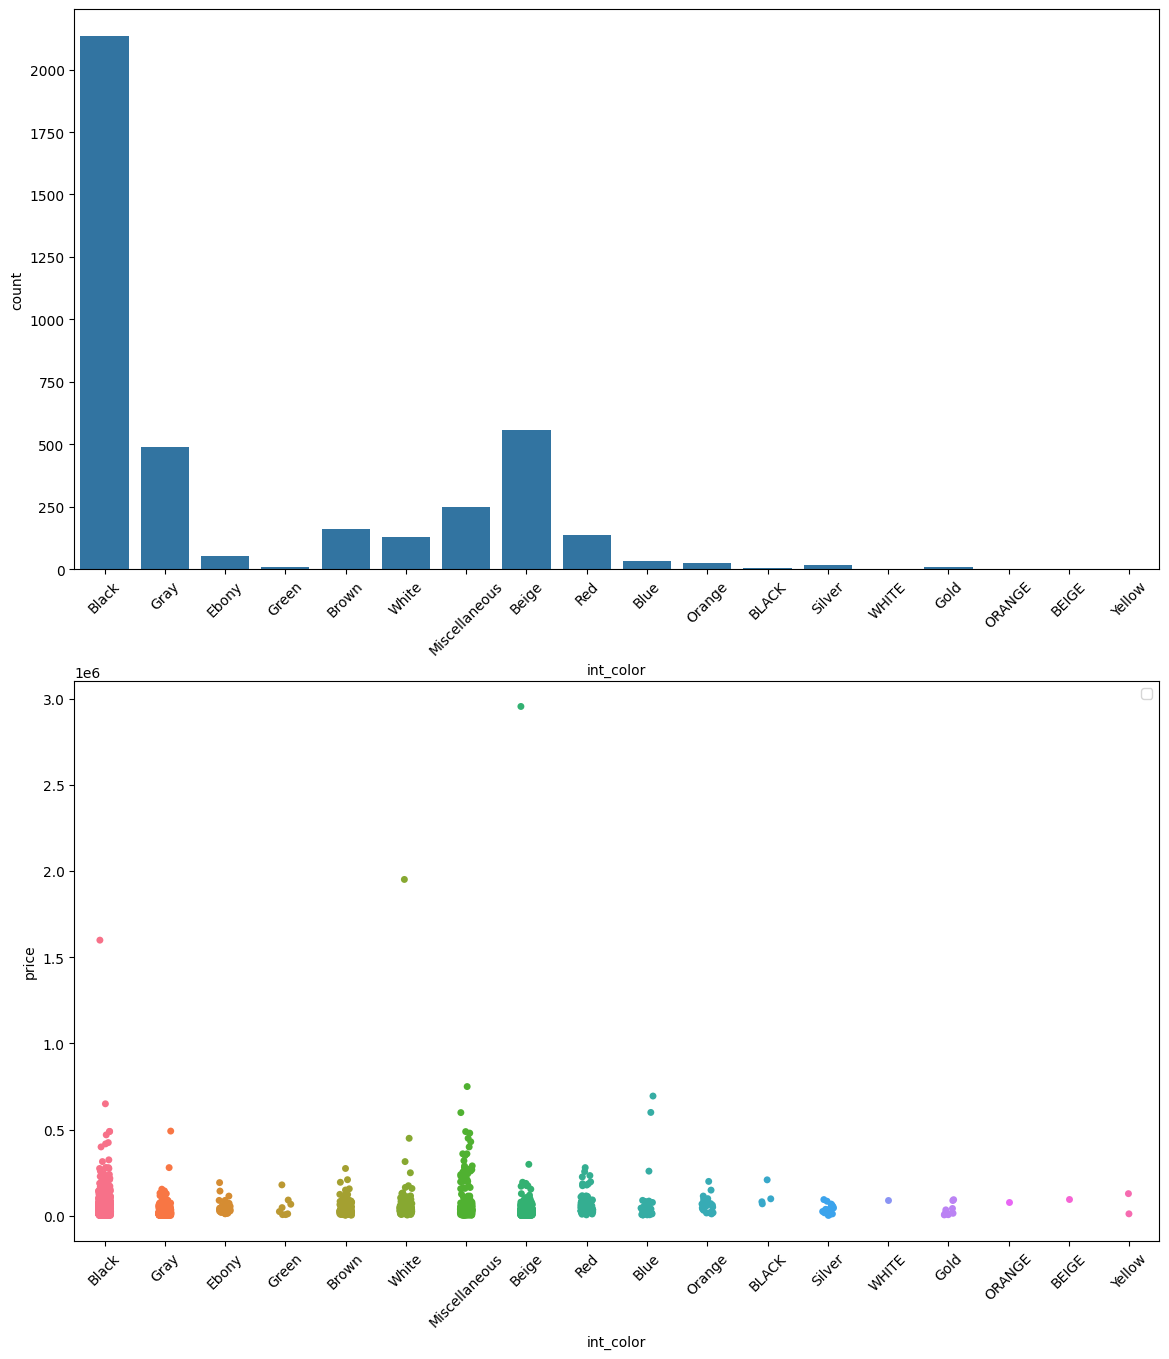

In [41]:
# Analysing Internal color
color_data['int_color'] = color_data['int_col'].apply(get_color)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.int_color)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.int_color,y=color_data.price,hue=color_data.int_color)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


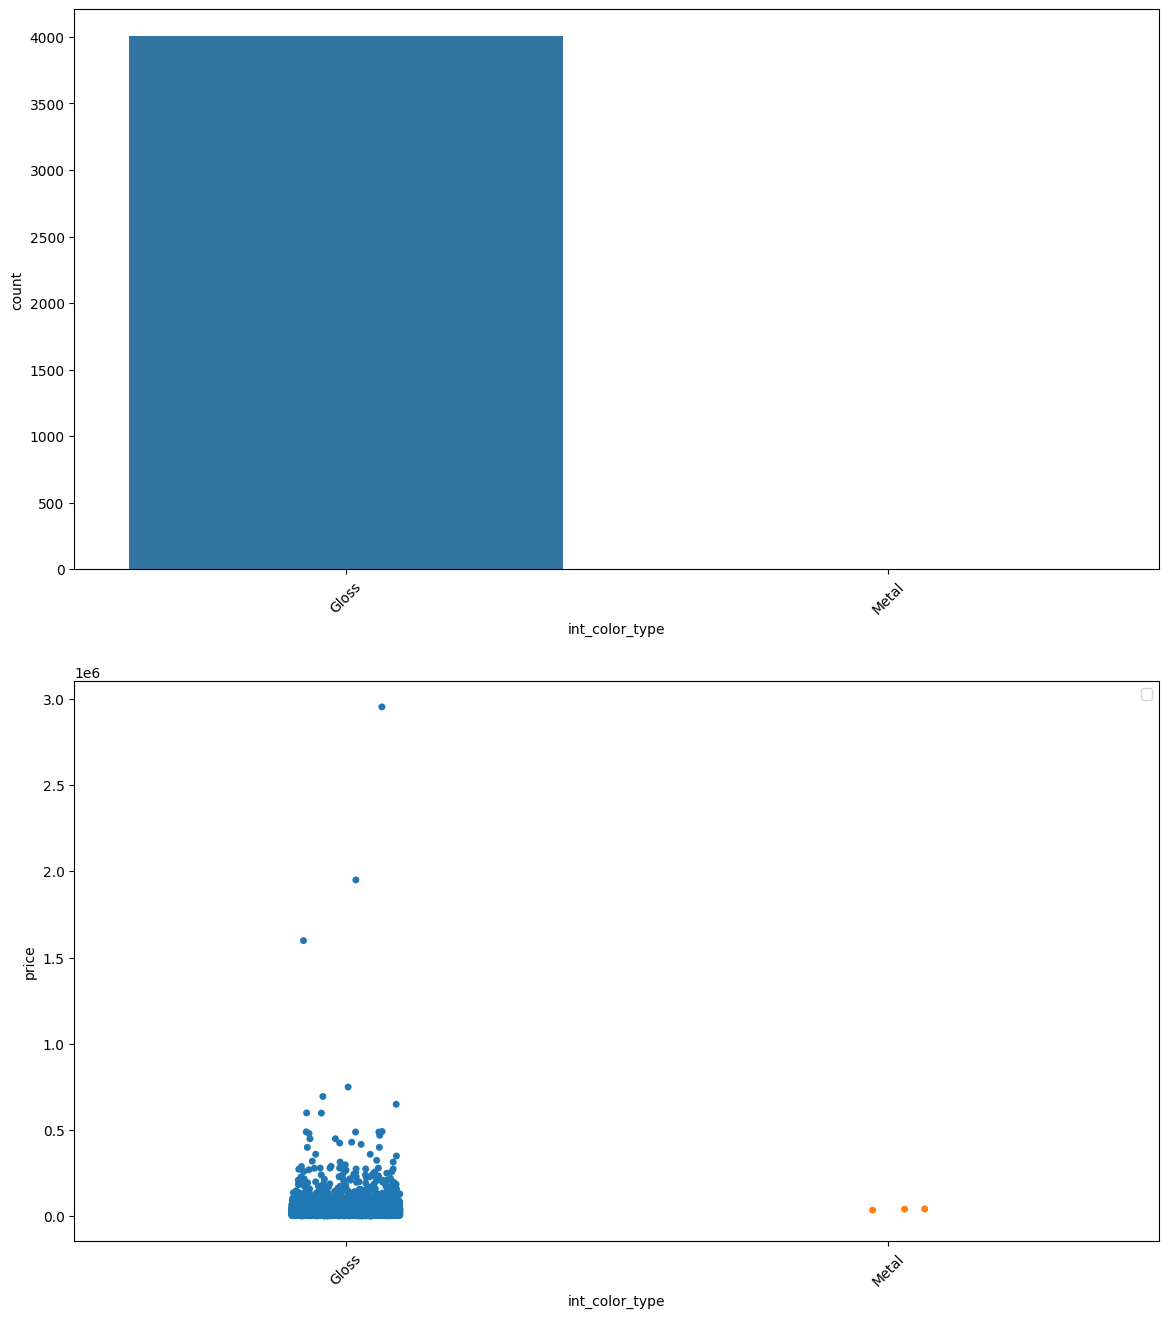

In [42]:
color_data['int_color_type'] = color_data['int_col'].apply(get_color_type)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.int_color_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.int_color_type,y=color_data.price,hue=color_data.int_color_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


#### 1.6.7 Accident

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/2273496196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  accident_data['accident'].fillna('None reported',inplace=True)


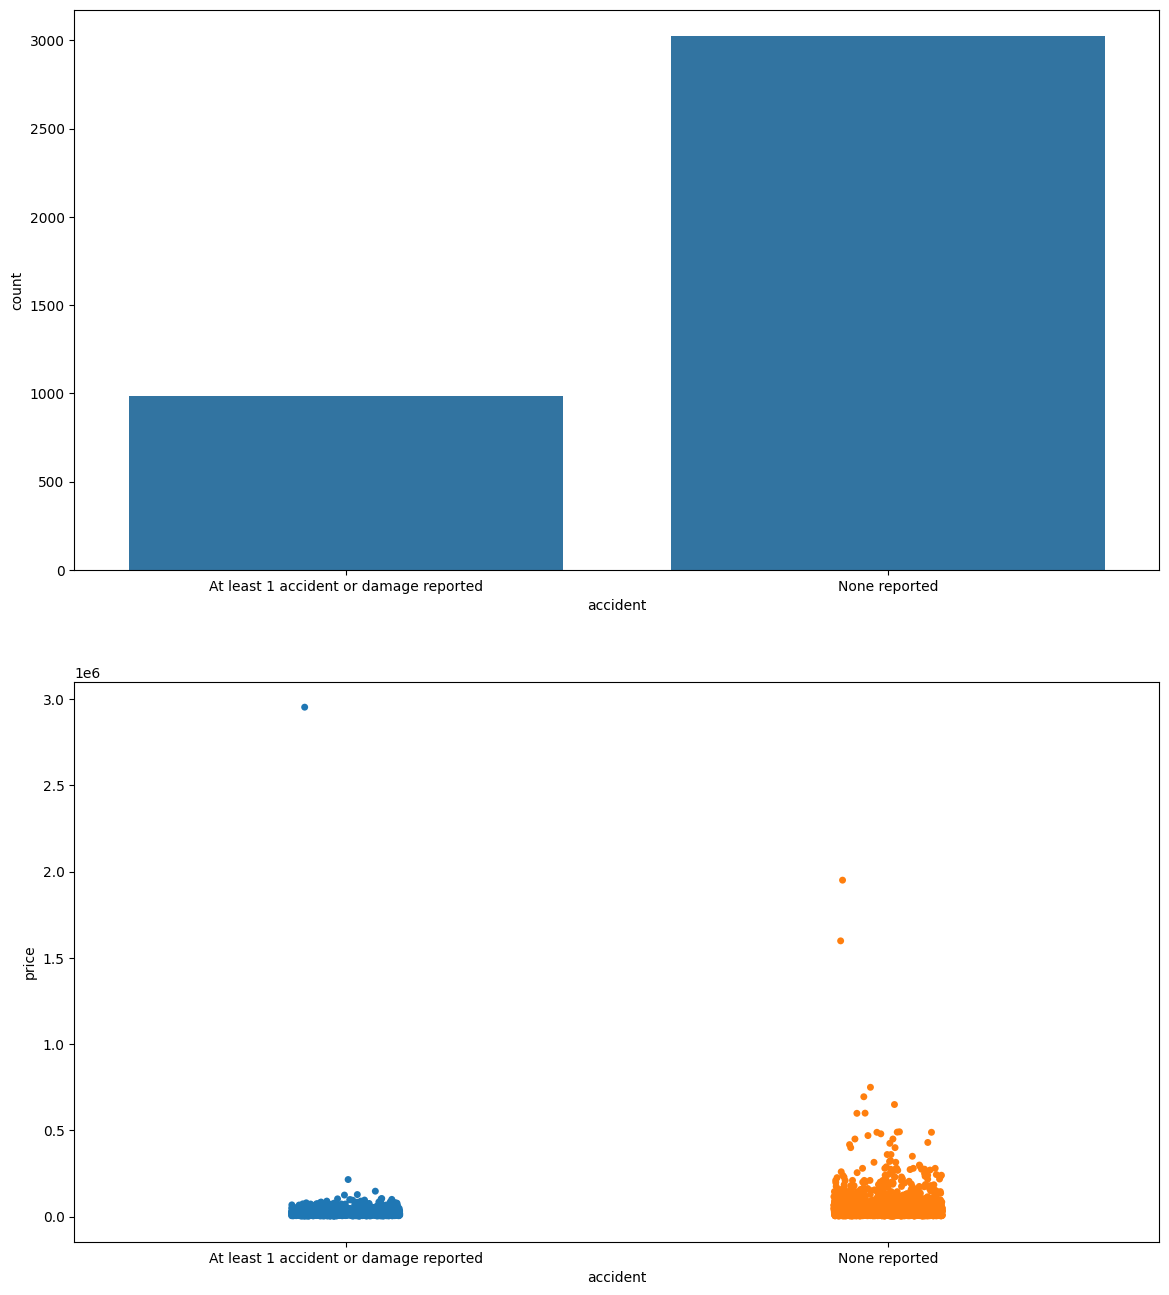

,accident,count,mean,median,std
0,At least 1 accident or damage reported,986,28831.500000,20900.0,95401.765975
1,None reported,3023,49681.072114,35690.0,71716.321914


In [43]:
# Analysing accident
accident_data  = df.copy()

accident_data['accident'].fillna('None reported',inplace=True)
plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=accident_data.accident)

plt.subplot(212)
sns.stripplot(x=accident_data.accident,y=accident_data.price,hue=accident_data.accident)
plt.show()

accident_data.groupby('accident')['price'].agg(['count','mean','median','std']).reset_index()


#### 1.6.8 Clean Title

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/1627584503.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  title_data['clean_title'].fillna('No',inplace=True)


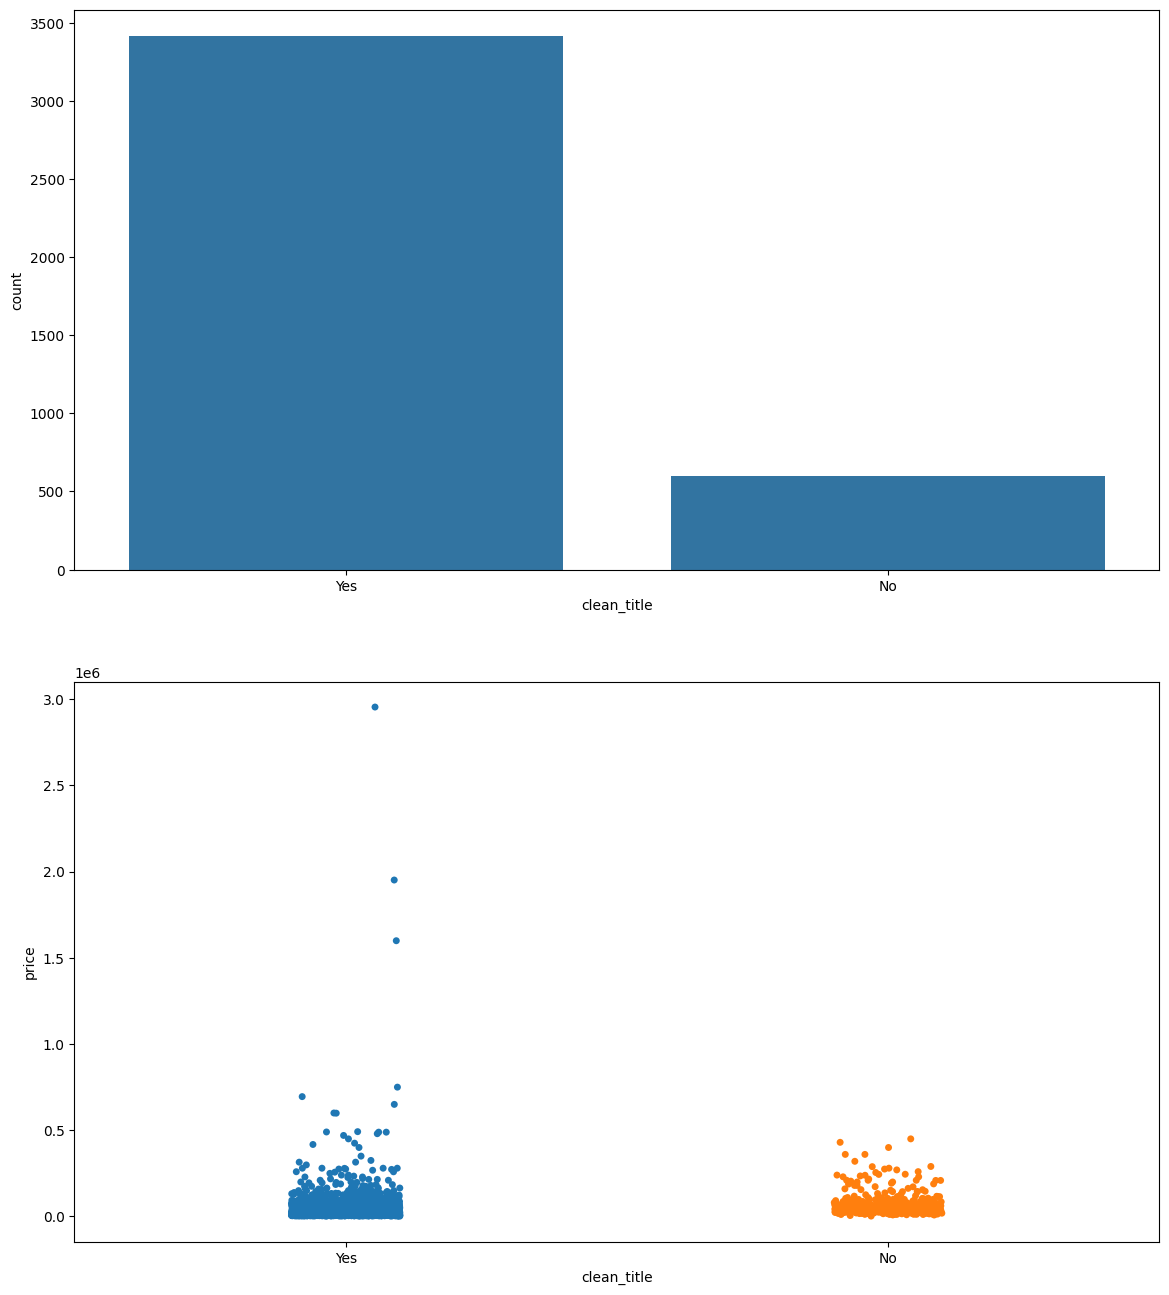

,clean_title,count,mean,median,std
0,No,596,60695.077181,42996.5,57982.778955
1,Yes,3413,41734.390272,29000.0,81472.770029


In [44]:
# Analysing clean title
title_data = df.copy()
title_data['clean_title'].fillna('No',inplace=True)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=title_data.clean_title)

plt.subplot(212)
sns.stripplot(x=title_data.clean_title,y=title_data.price,hue=title_data.clean_title)
plt.show()

title_data.groupby('clean_title')['price'].agg(['count','mean','median','std']).reset_index()


## 2. Data Preprocessing

### 2.1 Handling Null Values

The rationale of handling null values can be found in [1.3 analysis of null value](#13-analysis-of-null-values)

In [45]:
def fill_missing(data):
    data = data.copy()
    
    # Filling missing fuel type from engine description and model name
    data['fuel_type'].fillna('NA',inplace=True)
    data['fuel_type2'] = data['engine'].apply(get_fuel_type)
    data['fuel_type3'] = data['model'].apply(get_fuel_type)

    data['fuel_type'] = np.where(
        data.fuel_type.isin(['NA','–','not supported']),   # Condition
        np.where(data.fuel_type2 == 'NA',data.fuel_type3,data.fuel_type2),  # True Value
        data.fuel_type   # False value
    )

    data['accident'] = data['accident'].fillna('None reported')
    data['clean_title'] = data['clean_title'].fillna('No')
    
    return data

# combined_data = get_imputed_data(combined_data)
# original = get_imputed_data(original)
df = fill_missing(df)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/1714334401.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['fuel_type'].fillna('NA',inplace=True)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   float64
 4   fuel_type     4009 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      4009 non-null   object 
 10  clean_title   4009 non-null   object 
 11  price         4009 non-null   float64
 12  fuel_type2    4009 non-null   object 
 13  fuel_type3    4009 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 438.6+ KB


### 2.2 Data Cleaning

In [47]:
def cleaning_data(data):
    data = data.copy()
        
    # Extracting details from engine feature
    data['hp'] = data.engine.apply(get_hp)
    data['engine_'] = data.engine.apply(get_engine)
    data['cylinder'] = data.engine.apply(get_cylinder)
    data['fi'] = data.engine.apply(get_fi)
    data['turbo'] = data.engine.apply(get_turbo)

    # Extracting transmission details from transmission feature
    data['transmission_type'] = data.transmission.apply(get_trans_type)
    data['speed'] = data.transmission.apply(get_speed)

    # Extracting color details from color related features
    data['ext_color'] = data['ext_col'].apply(get_color)
    data['ext_color_type'] = data['ext_col'].apply(get_color_type)
    data['int_color'] = data['int_col'].apply(get_color)
    data['int_color_type'] = data['int_col'].apply(get_color_type)

    # Cleaning fuel type feature
    data['fuel_type'].replace(['ev','eV','Battery','Ev','Electric','motor'],'EV',inplace=True)
    data['fuel_type'].replace(['E85 Flex Fuel'],'Flex',inplace=True)
    data['fuel_type'].replace(['Plug-In Hybrid'],'Hybrid',inplace=True)

    # Cleaning cylinder feature
    data['cylinder'].replace(['Flat 6 Cylinder','Straight 6 Cylinder'],'H6',inplace=True)
    data['cylinder'].replace(['V-8'],'V8',inplace=True)
    data['cylinder'].replace(['I-4'],'I4',inplace=True)

    # Cleaning turbo feature
    data['turbo'].replace(['Supercharged'],'SC',inplace=True)
    data['turbo'].replace(['T/C'],'Turbo',inplace=True)

    # Cleaning transmission type feature
    data['transmission_type'].replace(['A/T','At','AT'],'Automatic',inplace=True)
    data['transmission_type'].replace(['M/T','Mt','MT'],'Manual',inplace=True)
    data['transmission_type'].replace(['CVT','Automatic CVT'],'Variable',inplace=True)

    # Cleaning External/Internal color
    data['int_color']  = data['int_color'].str.lower()
    data['ext_color']  = data['ext_color'].str.lower()

    # Cleaning External/Internal color type
    data['ext_color_type'].replace(['metal'],'Metallic',inplace=True)
    data['int_color_type'].replace(['Metal'],'Metallic',inplace=True)

    # Imputing median value for NA values in hp,engine_(volume of engine) and speed(TRANSMISSION) feature
    hp_median = data.groupby('cylinder')['hp'].transform(lambda x:x.median()).fillna(data.hp.median())
    data['hp'] = np.where(data.hp.isna(), hp_median, data.hp)

    engine_median = data.groupby('cylinder')['engine_'].transform(lambda x: x.median()).fillna(data.engine_.median())
    data['engine_'] = np.where(data.engine_.isna(), engine_median, data.engine_)

    speed_median = data.groupby('transmission_type')['speed'].transform(lambda x: x.median()).fillna(data.speed.median())
    data['speed'] = np.where(data.speed.isna(), speed_median, data.speed)
    
    return data

df = cleaning_data(df)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/3531768301.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['fuel_type'].replace(['ev','eV','Battery','Ev','Electric','motor'],'EV',inplace=True)
/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_74767/3531768301.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              4009 non-null   object 
 1   model              4009 non-null   object 
 2   model_year         4009 non-null   int64  
 3   milage             4009 non-null   float64
 4   fuel_type          4009 non-null   object 
 5   engine             4009 non-null   object 
 6   transmission       4009 non-null   object 
 7   ext_col            4009 non-null   object 
 8   int_col            4009 non-null   object 
 9   accident           4009 non-null   object 
 10  clean_title        4009 non-null   object 
 11  price              4009 non-null   float64
 12  fuel_type2         4009 non-null   object 
 13  fuel_type3         4009 non-null   object 
 14  hp                 4009 non-null   object 
 15  engine_            4009 non-null   object 
 16  cylinder           4009 

### 2.3 Feature Engineering

In [49]:
def add_features(data):
    data = data.copy()
    current_year = datetime.datetime.now().year
    # Creating car age 
    data['car_age'] = current_year - data.model_year + 1

    # Creating mileage per year
    data['mileage_per_year'] = data['milage'] / data['car_age']

    # # Creating mileage with age
    # data['mileage_with_age'] = data.groupby('car_age')['milage'].transform('mean').fillna(data.milage.mean())

    # # Creating mileage per year with age
    # data['mileage_per_year_with_age'] = data.groupby('car_age')['mileage_per_year'].transform('mean').fillna(data.mileage_per_year.mean())

    # Creating power to weight ratio
    data['power_to_weight_ratio'] = (data['hp'] / data['engine_']).astype(float)

    # Adding separate feature for luxury and supercar brands
    luxury_and_supercar_brands = [ "Mercedes-Benz", "BMW", "Audi", "Lexus", "Acura", "Jaguar", 
                                  "INFINITI", "Cadillac", "Lincoln", "Volvo", "Tesla",
                                  "Maserati", "Bentley", "Genesis", "Ferrari", "Rolls-Royce",
                                  "Aston", "McLaren", "Bugatti", "Lamborghini", "Porsche"]
    data['is_luxury_super']  = data.brand.isin(luxury_and_supercar_brands).astype(int)
    
    return data
df = add_features(df)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand                  4009 non-null   object 
 1   model                  4009 non-null   object 
 2   model_year             4009 non-null   int64  
 3   milage                 4009 non-null   float64
 4   fuel_type              4009 non-null   object 
 5   engine                 4009 non-null   object 
 6   transmission           4009 non-null   object 
 7   ext_col                4009 non-null   object 
 8   int_col                4009 non-null   object 
 9   accident               4009 non-null   object 
 10  clean_title            4009 non-null   object 
 11  price                  4009 non-null   float64
 12  fuel_type2             4009 non-null   object 
 13  fuel_type3             4009 non-null   object 
 14  hp                     4009 non-null   object 
 15  engi

### 2.4 Data Type Conversion

In [51]:
def set_dtypes(data):
    data = data.copy()

    data['hp'] = data['hp'].astype(float)
    data['engine_'] = data['engine_'].astype(float)
    data['speed'] = data['speed'].astype(float)
    
    return data
df=set_dtypes(df)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand                  4009 non-null   object 
 1   model                  4009 non-null   object 
 2   model_year             4009 non-null   int64  
 3   milage                 4009 non-null   float64
 4   fuel_type              4009 non-null   object 
 5   engine                 4009 non-null   object 
 6   transmission           4009 non-null   object 
 7   ext_col                4009 non-null   object 
 8   int_col                4009 non-null   object 
 9   accident               4009 non-null   object 
 10  clean_title            4009 non-null   object 
 11  price                  4009 non-null   float64
 12  fuel_type2             4009 non-null   object 
 13  fuel_type3             4009 non-null   object 
 14  hp                     4009 non-null   float64
 15  engi

### 2.5 Data Encoding for Categorical Variables

In [53]:
def encode(data):
    data = data.copy()
    

    # label encoding should be avoided!!!!!!!!!!!!!!?

    l_enc = LabelEncoder()
    data['brand'] = l_enc.fit_transform(data['brand'])
    data['model'] = l_enc.fit_transform(data['model'])
    data['cylinder'] = l_enc.fit_transform(data['cylinder'])
    # data['ext_color'] = l_enc.fit_transform(data['ext_color'])
    # data['int_color'] = l_enc.fit_transform(data['int_color'])

    # OneHot encoding on features
    cat_feat = ['fuel_type','accident','clean_title','fi','turbo','transmission_type','ext_color_type','int_color_type']
    data = pd.get_dummies(data,columns=cat_feat,dtype=int,drop_first=True)
    
    return data

df = encode(df)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   brand                       4009 non-null   int64  
 1   model                       4009 non-null   int64  
 2   model_year                  4009 non-null   int64  
 3   milage                      4009 non-null   float64
 4   engine                      4009 non-null   object 
 5   transmission                4009 non-null   object 
 6   ext_col                     4009 non-null   object 
 7   int_col                     4009 non-null   object 
 8   price                       4009 non-null   float64
 9   fuel_type2                  4009 non-null   object 
 10  fuel_type3                  4009 non-null   object 
 11  hp                          4009 non-null   float64
 12  engine_                     4009 non-null   float64
 13  cylinder                    4009 

### 2.6 Postprocessing

In [55]:
df.drop(['engine', 'transmission', 'ext_col', 'int_col', 'fuel_type2',
       'fuel_type3','ext_color','int_color'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   brand                       4009 non-null   int64  
 1   model                       4009 non-null   int64  
 2   model_year                  4009 non-null   int64  
 3   milage                      4009 non-null   float64
 4   price                       4009 non-null   float64
 5   hp                          4009 non-null   float64
 6   engine_                     4009 non-null   float64
 7   cylinder                    4009 non-null   int64  
 8   speed                       4009 non-null   float64
 9   car_age                     4009 non-null   int64  
 10  mileage_per_year            4009 non-null   float64
 11  power_to_weight_ratio       4009 non-null   float64
 12  is_luxury_super             4009 non-null   int64  
 13  fuel_type_EV                4009 

In [56]:
df.describe()

,brand,model,model_year,milage,price,hp,engine_,cylinder,speed,car_age,...,turbo_SC,turbo_Turbo,turbo_Twin Turbo,turbo_intercooled,transmission_type_Dual,transmission_type_Fixed,transmission_type_Manual,transmission_type_Variable,ext_color_type_Metallic,int_color_type_Metallic
count,4009.000000,4009.000000,4009.000000,4009.000000,4.009000e+03,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,...,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000
mean,23.635819,926.869294,2015.515590,64717.551010,4.455319e+04,327.809928,3.648728,9.670242,6.895984,9.484410,...,0.002494,0.043901,0.030182,0.000499,0.099277,0.000249,0.098029,0.025942,0.047643,0.000748
std,16.380885,548.336917,6.104816,52296.599459,7.871064e+04,118.094493,1.388051,6.187201,1.385124,6.104816,...,0.049888,0.204901,0.171109,0.022333,0.299070,0.015794,0.297392,0.158981,0.213036,0.027349
min,0.000000,0.000000,1974.000000,100.000000,2.000000e+03,70.000000,0.650000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,480.000000,2012.000000,23044.000000,1.720000e+04,252.000000,2.500000,5.000000,6.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,894.000000,2017.000000,52775.000000,3.100000e+04,310.000000,3.500000,7.000000,7.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,1405.000000,2020.000000,94100.000000,4.999000e+04,405.000000,4.600000,18.000000,7.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,56.000000,1897.000000,2024.000000,405000.000000,2.954083e+06,1020.000000,8.400000,21.000000,10.000000,51.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Model Fitting

In [57]:
class LinearRegressionSPModel:
    def __init__(self, X, y):
        self.X = add_constant(X)
        self.y = y
        self.model = OLS(self.y, self.X).fit()

    def summary(self):
        # returns the model summary similar to SPSS output
        return self.model.summary()

    def detailed_stats(self):
        # Provides beta coefficients, standard errors, t-stats, p-values, and the F-test (Just like SPSS)
        betas = self.model.params
        std_errors = self.model.bse
        t_stats = self.model.tvalues
        p_values = self.model.pvalues
        f_stat = self.model.fvalue
        f_p_value = self.model.f_pvalue

        stats_df = pd.DataFrame({
            'Variable': self.X.columns,
            'Beta': betas,
            'Std. Error': std_errors,
            't-Statistic': t_stats,
            'P-Value': p_values
        })

        model_info = pd.DataFrame({
            'Metric': ['F-Statistic', 'F P-Value'],
            'Value': [f_stat, f_p_value]
        })

        return stats_df, model_info

    def multicollinearity_check(self):
        # Calculates Variance Inflation Factor (VIF) for each variable 
        vif_data = pd.DataFrame()
        vif_data["Variable"] = self.X.columns
        vif_data["VIF"] = [variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])]
        return vif_data

    def performance_metrics(self):
        # Returns key performance metrics like R-squared and MSE (For now, we do C_P all later)
        r_squared = self.model.rsquared
        adj_r_squared = self.model.rsquared_adj
        mse = np.mean(self.model.resid ** 2)
        return pd.DataFrame({
            'Metric': ['R-Squared', 'Adjusted R-Squared', 'Mean Squared Error'],
            'Value': [r_squared, adj_r_squared, mse]
        })

    def plot_residuals(self):
        # Plots residuals to assess the fit, linearity, and heteroscedasticity
        residuals = self.model.resid
        predicted = self.model.fittedvalues

        plt.figure(figsize=(10, 6))
        plt.scatter(predicted, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()

    def best_subset_selection(self, max_features=None):
        # Performs best subset selection for the given predictors
        if max_features is None:
            max_features = self.X.shape[1] - 1  # Exclude constant term

        results = []
        for k in range(1, max_features + 1):
            for subset in combinations(self.X.columns[1:], k):
                X_subset = self.X[list(subset) + ['const']]
                model = OLS(self.y, X_subset).fit()
                aic = model.aic
                results.append((subset, model.rsquared_adj, aic))

        best_model = max(results, key=lambda x: x[1])
        best_features, best_adj_r2, best_aic = best_model

        return {
            'Best Subset': best_features,
            'Adjusted R-squared': best_adj_r2,
            'AIC': best_aic
        }


In [58]:
# # Prepare the data
# X = df.drop(columns=['price'])  # Predictors
# y = df['price']  # Target variable (price)

# # Instantiate and fit the model
# model = LinearRegressionSPModel(X, y)

# # Summary of the model
# print(model.summary())

# # Detailed statistics
# stats_df, model_info = model.detailed_stats()
# print(stats_df)
# print(model_info)

# # Multicollinearity check (VIF)
# vif_data = model.multicollinearity_check()
# print(vif_data)

# # Performance metrics
# performance_metrics = model.performance_metrics()
# print(performance_metrics)


In [59]:
# Assuming df is your dataframe and 'price' is your target variable
X = df.drop(columns='price')
y = df['price']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with cross-validation to find the best alpha
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)
lasso.fit(X_scaled, y)

# Get the non-zero coefficients
selected_features = np.where(lasso.coef_ != 0)[0]

# Create a new dataframe with only the selected features
X_selected = X.iloc[:, selected_features]

# Now you can fit your linear regression model using X_selected
model = LinearRegressionSPModel(X_selected, y)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     39.03
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          3.53e-180
Time:                        05:55:30   Log-Likelihood:                -50413.
No. Observations:                4009   AIC:                         1.009e+05
Df Residuals:                    3981   BIC:                         1.011e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [60]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Assuming X_selected is your DataFrame with selected features
vif_results = calculate_vif(X_selected)
print(vif_results)


                    Variable        VIF
0                      brand   1.117152
1                 model_year  89.299757
2                     milage   6.463863
3                         hp   2.380770
4                    engine_   2.195856
5                   cylinder   1.203661
6                    car_age  13.882874
7           mileage_per_year   3.918871
8            is_luxury_super   1.250696
9               fuel_type_EV   3.023826
10            fuel_type_Flex   2.182918
11        fuel_type_Gasoline   5.777708
12          fuel_type_Hybrid   3.226508
13           fuel_type_Motor   1.043948
14              fuel_type_NA   1.643751
15    accident_None reported   1.120385
16           clean_title_Yes   1.463429
17                    fi_GDI   1.744819
18                   fi_MPFI   1.185623
19                   fi_TFSI   1.104745
20                    fi_TSI   1.016181
21                  turbo_SC   1.032975
22               turbo_Turbo   1.465410
23          turbo_Twin Turbo   1.242667


In [61]:
X_selected_refined = X_selected.drop(columns='model_year')
# Refit the linear regression model with the refined feature set
model_refined = LinearRegressionSPModel(X_selected_refined, y)

# Print the summary of the refined model
print(model_refined.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     39.03
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          3.53e-180
Time:                        05:55:30   Log-Likelihood:                -50413.
No. Observations:                4009   AIC:                         1.009e+05
Df Residuals:                    3981   BIC:                         1.011e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [62]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Assuming X_selected is your DataFrame with selected features
vif_results = calculate_vif(X_selected_refined)
print(vif_results)


                    Variable        VIF
0                      brand   3.287933
1                     milage  15.998913
2                         hp  20.224516
3                    engine_  16.238284
4                   cylinder   3.984052
5                    car_age  13.142975
6           mileage_per_year  12.684186
7            is_luxury_super   2.310141
8               fuel_type_EV   2.403156
9             fuel_type_Flex   1.675062
10        fuel_type_Gasoline  17.973197
11          fuel_type_Hybrid   2.126577
12           fuel_type_Motor   1.022966
13              fuel_type_NA   1.527440
14    accident_None reported   4.291766
15           clean_title_Yes   8.755887
16                    fi_GDI   1.892197
17                   fi_MPFI   1.219480
18                   fi_TFSI   1.102954
19                    fi_TSI   1.015814
20                  turbo_SC   1.035127
21               turbo_Turbo   1.449374
22          turbo_Twin Turbo   1.277037
23    transmission_type_Dual   1.222339


## TODO
1. Simply use 11 original features?
2. Transform predictors/target variables?
3. multicolineariry? it seems to be the most serious issue